# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input/R5KrjnANiKVhLWAkpXhNBe'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.21KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

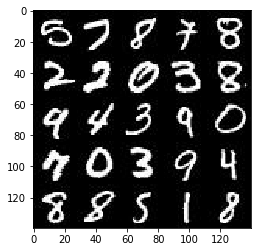

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

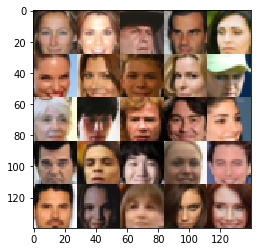

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width,image_height,image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, (None), name='learning_rate')
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    keep_prob = 0.8
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
                
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        
        # 14x14x64
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        bn2 = tf.nn.dropout(bn2, keep_prob)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # 7x7x128
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        bn3 = tf.nn.dropout(bn3, keep_prob)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # 4x4x256
        flat = tf.reshape(relu3, [-1, 4*4*256])
        
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_real)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """    
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    show_every = 50
    print_every = 10
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 2.4809... Generator Loss: 0.1848
Epoch 0/2... Discriminator Loss: 2.0722... Generator Loss: 0.3919
Epoch 0/2... Discriminator Loss: 1.8770... Generator Loss: 0.4091
Epoch 0/2... Discriminator Loss: 1.7598... Generator Loss: 0.4590


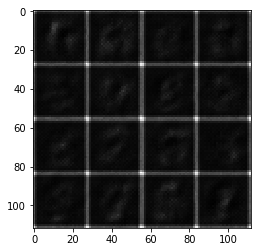

Epoch 0/2... Discriminator Loss: 2.0938... Generator Loss: 1.4301
Epoch 0/2... Discriminator Loss: 1.5365... Generator Loss: 0.6051
Epoch 0/2... Discriminator Loss: 1.6929... Generator Loss: 0.4820
Epoch 0/2... Discriminator Loss: 1.6149... Generator Loss: 0.3876
Epoch 0/2... Discriminator Loss: 1.6080... Generator Loss: 0.4609


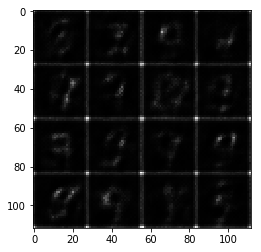

Epoch 0/2... Discriminator Loss: 1.4978... Generator Loss: 0.5203
Epoch 0/2... Discriminator Loss: 1.4473... Generator Loss: 0.7524
Epoch 0/2... Discriminator Loss: 1.5624... Generator Loss: 0.4747
Epoch 0/2... Discriminator Loss: 1.3971... Generator Loss: 0.7379
Epoch 0/2... Discriminator Loss: 1.4943... Generator Loss: 0.5833


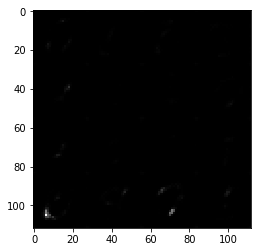

Epoch 0/2... Discriminator Loss: 1.6312... Generator Loss: 0.4288
Epoch 0/2... Discriminator Loss: 1.5021... Generator Loss: 0.5147
Epoch 0/2... Discriminator Loss: 1.3184... Generator Loss: 0.8805
Epoch 0/2... Discriminator Loss: 1.3336... Generator Loss: 0.5601
Epoch 0/2... Discriminator Loss: 1.2829... Generator Loss: 1.1659


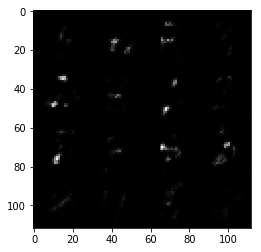

Epoch 0/2... Discriminator Loss: 1.3569... Generator Loss: 0.8608
Epoch 0/2... Discriminator Loss: 1.4060... Generator Loss: 0.5129
Epoch 0/2... Discriminator Loss: 1.2276... Generator Loss: 1.0773
Epoch 0/2... Discriminator Loss: 1.0693... Generator Loss: 0.9441
Epoch 0/2... Discriminator Loss: 1.1162... Generator Loss: 1.5951


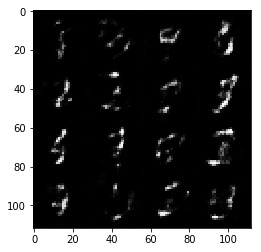

Epoch 0/2... Discriminator Loss: 1.2066... Generator Loss: 0.8388
Epoch 0/2... Discriminator Loss: 1.1523... Generator Loss: 1.6552
Epoch 0/2... Discriminator Loss: 1.0905... Generator Loss: 1.3195
Epoch 0/2... Discriminator Loss: 1.1751... Generator Loss: 0.7362
Epoch 0/2... Discriminator Loss: 1.0249... Generator Loss: 1.2444


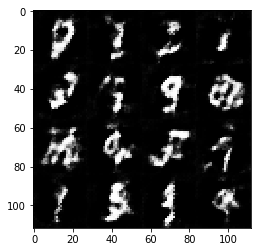

Epoch 0/2... Discriminator Loss: 0.9888... Generator Loss: 0.9221
Epoch 0/2... Discriminator Loss: 1.3719... Generator Loss: 0.7455
Epoch 0/2... Discriminator Loss: 1.2024... Generator Loss: 1.0825
Epoch 0/2... Discriminator Loss: 1.4407... Generator Loss: 0.4608
Epoch 0/2... Discriminator Loss: 1.1234... Generator Loss: 1.0119


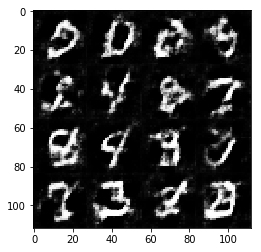

Epoch 0/2... Discriminator Loss: 1.8369... Generator Loss: 0.3564
Epoch 0/2... Discriminator Loss: 1.7281... Generator Loss: 0.4867
Epoch 0/2... Discriminator Loss: 1.4400... Generator Loss: 0.7256
Epoch 0/2... Discriminator Loss: 1.1491... Generator Loss: 1.3925
Epoch 0/2... Discriminator Loss: 1.4760... Generator Loss: 1.4381


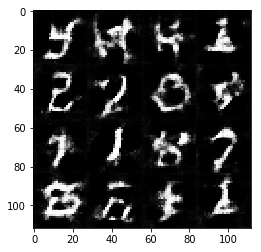

Epoch 0/2... Discriminator Loss: 1.1477... Generator Loss: 0.8700
Epoch 0/2... Discriminator Loss: 1.4828... Generator Loss: 1.2845
Epoch 0/2... Discriminator Loss: 1.6032... Generator Loss: 0.6154
Epoch 0/2... Discriminator Loss: 1.2391... Generator Loss: 0.6209
Epoch 0/2... Discriminator Loss: 1.2346... Generator Loss: 1.0017


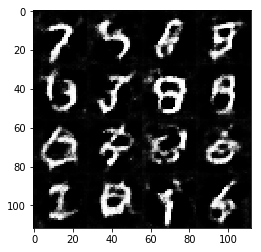

Epoch 0/2... Discriminator Loss: 1.1753... Generator Loss: 0.8372
Epoch 0/2... Discriminator Loss: 1.0745... Generator Loss: 0.7212
Epoch 0/2... Discriminator Loss: 1.1603... Generator Loss: 0.7705
Epoch 0/2... Discriminator Loss: 1.4014... Generator Loss: 1.2408
Epoch 0/2... Discriminator Loss: 1.5536... Generator Loss: 0.4275


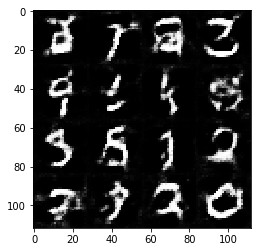

Epoch 0/2... Discriminator Loss: 1.0827... Generator Loss: 1.0287
Epoch 0/2... Discriminator Loss: 1.3055... Generator Loss: 1.0725
Epoch 0/2... Discriminator Loss: 1.5387... Generator Loss: 0.4617
Epoch 0/2... Discriminator Loss: 1.2987... Generator Loss: 0.5772
Epoch 0/2... Discriminator Loss: 1.2248... Generator Loss: 0.6330


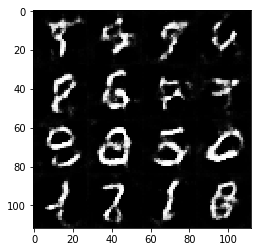

Epoch 0/2... Discriminator Loss: 1.3223... Generator Loss: 0.5678
Epoch 0/2... Discriminator Loss: 1.1306... Generator Loss: 0.9336
Epoch 0/2... Discriminator Loss: 1.6257... Generator Loss: 0.3662
Epoch 0/2... Discriminator Loss: 1.2922... Generator Loss: 0.6740
Epoch 0/2... Discriminator Loss: 1.0676... Generator Loss: 0.9905


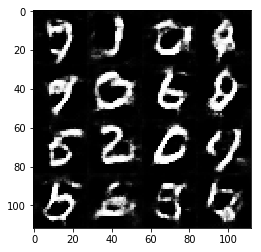

Epoch 0/2... Discriminator Loss: 1.2111... Generator Loss: 0.7745
Epoch 0/2... Discriminator Loss: 1.0520... Generator Loss: 0.9692
Epoch 0/2... Discriminator Loss: 1.4507... Generator Loss: 0.5550
Epoch 0/2... Discriminator Loss: 1.3121... Generator Loss: 0.7012
Epoch 0/2... Discriminator Loss: 1.2658... Generator Loss: 1.1340


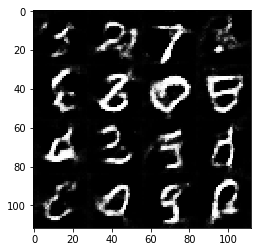

Epoch 0/2... Discriminator Loss: 1.1473... Generator Loss: 0.9091
Epoch 0/2... Discriminator Loss: 1.2130... Generator Loss: 1.1117
Epoch 0/2... Discriminator Loss: 1.0087... Generator Loss: 0.9517
Epoch 0/2... Discriminator Loss: 1.2729... Generator Loss: 0.9564
Epoch 0/2... Discriminator Loss: 1.2331... Generator Loss: 0.6445


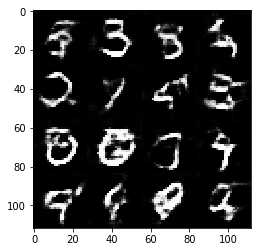

Epoch 0/2... Discriminator Loss: 1.4101... Generator Loss: 0.4631
Epoch 0/2... Discriminator Loss: 1.1474... Generator Loss: 1.2510
Epoch 0/2... Discriminator Loss: 1.2561... Generator Loss: 0.7806
Epoch 0/2... Discriminator Loss: 1.2414... Generator Loss: 0.6966
Epoch 0/2... Discriminator Loss: 1.0274... Generator Loss: 0.9766


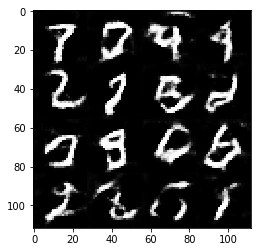

Epoch 0/2... Discriminator Loss: 1.4796... Generator Loss: 0.4600
Epoch 0/2... Discriminator Loss: 1.0555... Generator Loss: 1.1286
Epoch 0/2... Discriminator Loss: 1.1897... Generator Loss: 0.8455
Epoch 0/2... Discriminator Loss: 1.5200... Generator Loss: 0.4499
Epoch 0/2... Discriminator Loss: 1.0480... Generator Loss: 1.0054


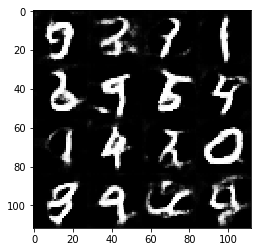

Epoch 0/2... Discriminator Loss: 0.9415... Generator Loss: 1.0228
Epoch 0/2... Discriminator Loss: 1.2702... Generator Loss: 0.8192
Epoch 0/2... Discriminator Loss: 1.3197... Generator Loss: 0.9566
Epoch 0/2... Discriminator Loss: 1.0983... Generator Loss: 0.8794
Epoch 0/2... Discriminator Loss: 1.1531... Generator Loss: 1.1156


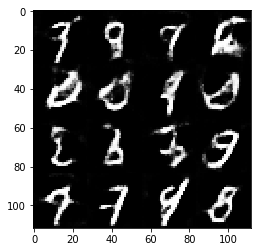

Epoch 0/2... Discriminator Loss: 1.1143... Generator Loss: 1.0310
Epoch 0/2... Discriminator Loss: 1.2647... Generator Loss: 0.9263
Epoch 0/2... Discriminator Loss: 1.3398... Generator Loss: 0.9867
Epoch 0/2... Discriminator Loss: 1.3733... Generator Loss: 0.7241
Epoch 0/2... Discriminator Loss: 1.1873... Generator Loss: 0.6420


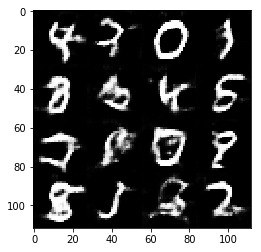

Epoch 0/2... Discriminator Loss: 1.1544... Generator Loss: 0.8793
Epoch 0/2... Discriminator Loss: 1.5209... Generator Loss: 0.4264
Epoch 0/2... Discriminator Loss: 1.0471... Generator Loss: 0.8538
Epoch 0/2... Discriminator Loss: 1.3318... Generator Loss: 0.4560
Epoch 0/2... Discriminator Loss: 1.0624... Generator Loss: 0.9104


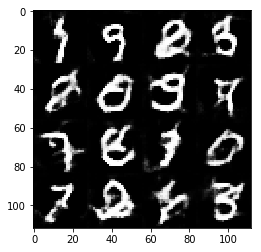

Epoch 0/2... Discriminator Loss: 1.1013... Generator Loss: 0.9619
Epoch 0/2... Discriminator Loss: 1.1113... Generator Loss: 1.1391
Epoch 0/2... Discriminator Loss: 1.1581... Generator Loss: 1.4822
Epoch 0/2... Discriminator Loss: 1.1088... Generator Loss: 0.7501
Epoch 0/2... Discriminator Loss: 1.1123... Generator Loss: 0.9745


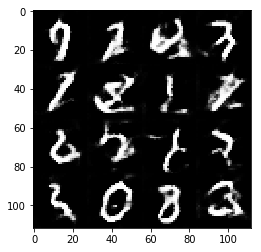

Epoch 0/2... Discriminator Loss: 1.1007... Generator Loss: 0.8361
Epoch 0/2... Discriminator Loss: 1.5070... Generator Loss: 0.5001
Epoch 0/2... Discriminator Loss: 0.9468... Generator Loss: 0.9823
Epoch 0/2... Discriminator Loss: 1.1697... Generator Loss: 0.6527
Epoch 0/2... Discriminator Loss: 1.2916... Generator Loss: 0.8572


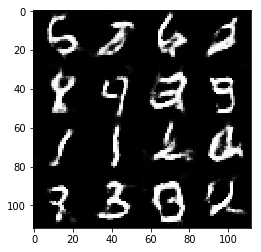

Epoch 0/2... Discriminator Loss: 1.2552... Generator Loss: 0.9994
Epoch 0/2... Discriminator Loss: 1.2514... Generator Loss: 0.6380
Epoch 0/2... Discriminator Loss: 1.2251... Generator Loss: 0.7642
Epoch 0/2... Discriminator Loss: 1.2023... Generator Loss: 1.4794
Epoch 0/2... Discriminator Loss: 1.3606... Generator Loss: 0.8956


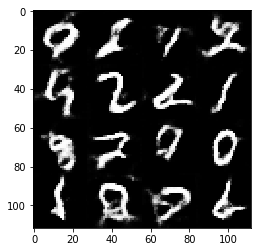

Epoch 0/2... Discriminator Loss: 0.9420... Generator Loss: 0.7743
Epoch 0/2... Discriminator Loss: 1.2948... Generator Loss: 0.4928
Epoch 0/2... Discriminator Loss: 1.1254... Generator Loss: 0.9123
Epoch 0/2... Discriminator Loss: 1.0027... Generator Loss: 0.7172
Epoch 0/2... Discriminator Loss: 1.0636... Generator Loss: 0.7793


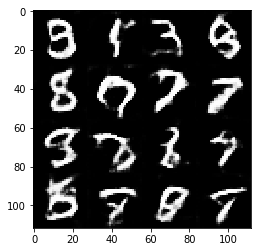

Epoch 0/2... Discriminator Loss: 1.3613... Generator Loss: 0.6561
Epoch 0/2... Discriminator Loss: 1.0717... Generator Loss: 1.2904
Epoch 0/2... Discriminator Loss: 1.1023... Generator Loss: 0.6980
Epoch 0/2... Discriminator Loss: 0.9512... Generator Loss: 0.8329
Epoch 0/2... Discriminator Loss: 1.3191... Generator Loss: 0.5817


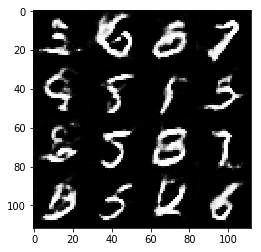

Epoch 0/2... Discriminator Loss: 1.2058... Generator Loss: 0.6835
Epoch 0/2... Discriminator Loss: 1.3323... Generator Loss: 0.4781
Epoch 0/2... Discriminator Loss: 1.0228... Generator Loss: 1.1603
Epoch 0/2... Discriminator Loss: 0.9472... Generator Loss: 1.1663
Epoch 0/2... Discriminator Loss: 1.2845... Generator Loss: 0.6549


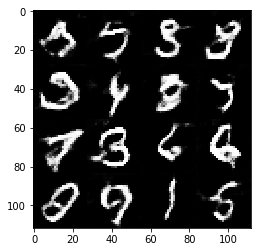

Epoch 0/2... Discriminator Loss: 0.8915... Generator Loss: 0.9801
Epoch 0/2... Discriminator Loss: 0.9505... Generator Loss: 0.8533
Epoch 0/2... Discriminator Loss: 0.8622... Generator Loss: 1.2716
Epoch 0/2... Discriminator Loss: 1.0330... Generator Loss: 0.9643
Epoch 0/2... Discriminator Loss: 1.2873... Generator Loss: 0.6021


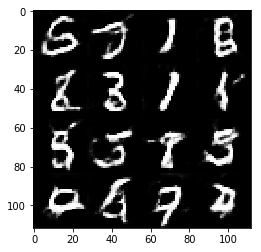

Epoch 0/2... Discriminator Loss: 1.0077... Generator Loss: 0.7748
Epoch 0/2... Discriminator Loss: 1.2173... Generator Loss: 1.3672
Epoch 0/2... Discriminator Loss: 1.2515... Generator Loss: 0.4853
Epoch 0/2... Discriminator Loss: 0.9559... Generator Loss: 0.8311
Epoch 0/2... Discriminator Loss: 1.3546... Generator Loss: 0.4573


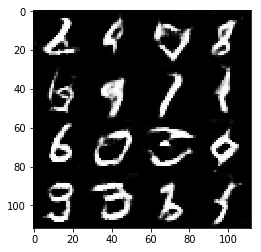

Epoch 0/2... Discriminator Loss: 1.1769... Generator Loss: 0.5045
Epoch 0/2... Discriminator Loss: 0.9956... Generator Loss: 1.6593
Epoch 0/2... Discriminator Loss: 1.0390... Generator Loss: 1.2235
Epoch 0/2... Discriminator Loss: 1.2323... Generator Loss: 0.9496
Epoch 0/2... Discriminator Loss: 1.0490... Generator Loss: 1.0755


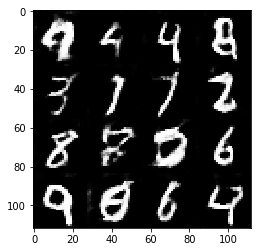

Epoch 0/2... Discriminator Loss: 1.1500... Generator Loss: 0.6429
Epoch 0/2... Discriminator Loss: 1.1775... Generator Loss: 1.1286
Epoch 0/2... Discriminator Loss: 0.8355... Generator Loss: 1.4473
Epoch 0/2... Discriminator Loss: 1.0855... Generator Loss: 0.9712
Epoch 0/2... Discriminator Loss: 0.8894... Generator Loss: 1.1663


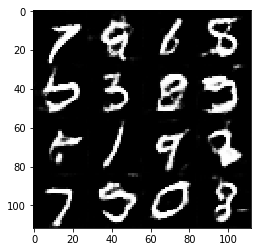

Epoch 0/2... Discriminator Loss: 0.9790... Generator Loss: 1.2361
Epoch 0/2... Discriminator Loss: 1.0332... Generator Loss: 0.7315
Epoch 0/2... Discriminator Loss: 1.2042... Generator Loss: 0.6655
Epoch 0/2... Discriminator Loss: 1.0598... Generator Loss: 0.8151
Epoch 0/2... Discriminator Loss: 1.1238... Generator Loss: 0.7537


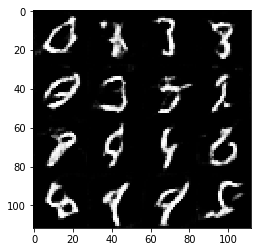

Epoch 0/2... Discriminator Loss: 1.3308... Generator Loss: 0.5695
Epoch 0/2... Discriminator Loss: 0.9409... Generator Loss: 1.5612
Epoch 0/2... Discriminator Loss: 1.1771... Generator Loss: 1.4460
Epoch 0/2... Discriminator Loss: 0.6746... Generator Loss: 1.1262
Epoch 0/2... Discriminator Loss: 0.9142... Generator Loss: 0.9321


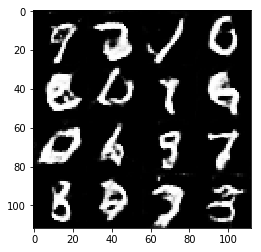

Epoch 0/2... Discriminator Loss: 0.9483... Generator Loss: 1.4991
Epoch 0/2... Discriminator Loss: 1.0028... Generator Loss: 0.8603
Epoch 0/2... Discriminator Loss: 1.5869... Generator Loss: 0.4212
Epoch 0/2... Discriminator Loss: 0.9540... Generator Loss: 0.8513
Epoch 0/2... Discriminator Loss: 0.7970... Generator Loss: 1.0070


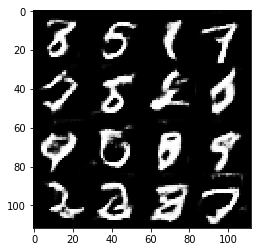

Epoch 0/2... Discriminator Loss: 1.1536... Generator Loss: 0.6537
Epoch 0/2... Discriminator Loss: 1.5383... Generator Loss: 2.4270
Epoch 0/2... Discriminator Loss: 0.8780... Generator Loss: 1.0516
Epoch 0/2... Discriminator Loss: 1.3972... Generator Loss: 0.5019
Epoch 0/2... Discriminator Loss: 1.1978... Generator Loss: 1.4333


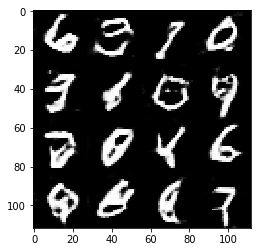

Epoch 0/2... Discriminator Loss: 1.0238... Generator Loss: 1.3772
Epoch 0/2... Discriminator Loss: 0.8683... Generator Loss: 1.1773
Epoch 0/2... Discriminator Loss: 0.8242... Generator Loss: 1.9227
Epoch 0/2... Discriminator Loss: 0.9847... Generator Loss: 0.8936
Epoch 0/2... Discriminator Loss: 0.9499... Generator Loss: 1.1893


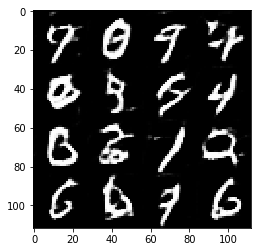

Epoch 0/2... Discriminator Loss: 1.2660... Generator Loss: 1.7678
Epoch 0/2... Discriminator Loss: 0.7997... Generator Loss: 1.3197
Epoch 0/2... Discriminator Loss: 1.8537... Generator Loss: 2.7979
Epoch 0/2... Discriminator Loss: 0.9338... Generator Loss: 1.5651
Epoch 0/2... Discriminator Loss: 0.8145... Generator Loss: 1.1032


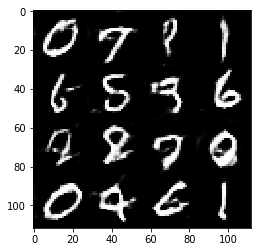

Epoch 0/2... Discriminator Loss: 0.7947... Generator Loss: 1.0392
Epoch 0/2... Discriminator Loss: 1.3596... Generator Loss: 0.6064
Epoch 0/2... Discriminator Loss: 1.3706... Generator Loss: 0.4735
Epoch 0/2... Discriminator Loss: 1.3915... Generator Loss: 0.4817
Epoch 0/2... Discriminator Loss: 1.1703... Generator Loss: 0.5720


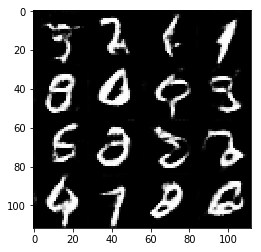

Epoch 0/2... Discriminator Loss: 0.8932... Generator Loss: 1.0440
Epoch 0/2... Discriminator Loss: 1.0764... Generator Loss: 0.7250
Epoch 0/2... Discriminator Loss: 0.7519... Generator Loss: 0.9939
Epoch 0/2... Discriminator Loss: 1.0544... Generator Loss: 1.2784
Epoch 0/2... Discriminator Loss: 0.9181... Generator Loss: 0.9297


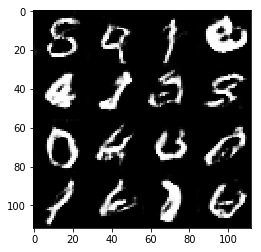

Epoch 0/2... Discriminator Loss: 0.9024... Generator Loss: 1.1596
Epoch 0/2... Discriminator Loss: 0.6342... Generator Loss: 1.9840
Epoch 0/2... Discriminator Loss: 0.7639... Generator Loss: 1.3425
Epoch 1/2... Discriminator Loss: 0.9016... Generator Loss: 1.0611
Epoch 1/2... Discriminator Loss: 1.3711... Generator Loss: 2.7307


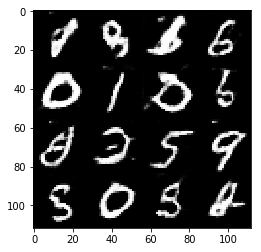

Epoch 1/2... Discriminator Loss: 1.1334... Generator Loss: 0.5911
Epoch 1/2... Discriminator Loss: 1.1229... Generator Loss: 0.6680
Epoch 1/2... Discriminator Loss: 0.7356... Generator Loss: 1.7631
Epoch 1/2... Discriminator Loss: 0.9784... Generator Loss: 0.6784
Epoch 1/2... Discriminator Loss: 1.4944... Generator Loss: 0.3627


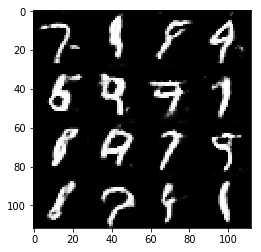

Epoch 1/2... Discriminator Loss: 0.9843... Generator Loss: 0.7725
Epoch 1/2... Discriminator Loss: 1.6174... Generator Loss: 0.4321
Epoch 1/2... Discriminator Loss: 0.8102... Generator Loss: 1.3792
Epoch 1/2... Discriminator Loss: 0.8525... Generator Loss: 0.9807
Epoch 1/2... Discriminator Loss: 1.0556... Generator Loss: 0.8617


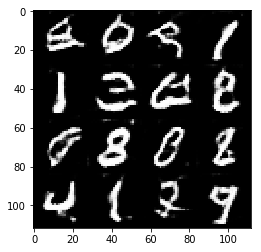

Epoch 1/2... Discriminator Loss: 1.0044... Generator Loss: 0.7980
Epoch 1/2... Discriminator Loss: 0.7919... Generator Loss: 1.0628
Epoch 1/2... Discriminator Loss: 0.9352... Generator Loss: 0.5598
Epoch 1/2... Discriminator Loss: 0.6671... Generator Loss: 1.6764
Epoch 1/2... Discriminator Loss: 0.9044... Generator Loss: 1.4956


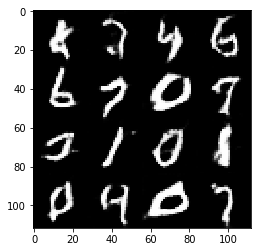

Epoch 1/2... Discriminator Loss: 0.9092... Generator Loss: 1.0374
Epoch 1/2... Discriminator Loss: 0.6468... Generator Loss: 1.2689
Epoch 1/2... Discriminator Loss: 1.0563... Generator Loss: 0.7252
Epoch 1/2... Discriminator Loss: 0.7168... Generator Loss: 1.2106
Epoch 1/2... Discriminator Loss: 0.9865... Generator Loss: 1.0219


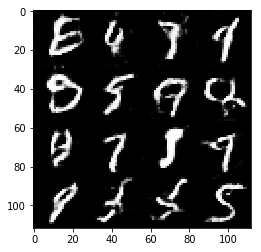

Epoch 1/2... Discriminator Loss: 0.8087... Generator Loss: 1.1746
Epoch 1/2... Discriminator Loss: 0.8347... Generator Loss: 1.4303
Epoch 1/2... Discriminator Loss: 0.9360... Generator Loss: 1.2412
Epoch 1/2... Discriminator Loss: 0.6613... Generator Loss: 1.0603
Epoch 1/2... Discriminator Loss: 1.4996... Generator Loss: 0.5402


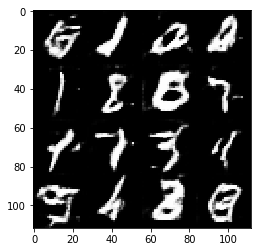

Epoch 1/2... Discriminator Loss: 1.0255... Generator Loss: 0.7343
Epoch 1/2... Discriminator Loss: 1.1458... Generator Loss: 1.7485
Epoch 1/2... Discriminator Loss: 0.8417... Generator Loss: 1.0503
Epoch 1/2... Discriminator Loss: 0.9230... Generator Loss: 1.0940
Epoch 1/2... Discriminator Loss: 1.0952... Generator Loss: 0.6814


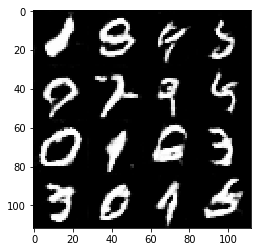

Epoch 1/2... Discriminator Loss: 1.0266... Generator Loss: 0.6961
Epoch 1/2... Discriminator Loss: 0.6372... Generator Loss: 1.5477
Epoch 1/2... Discriminator Loss: 1.3306... Generator Loss: 2.8336
Epoch 1/2... Discriminator Loss: 0.8262... Generator Loss: 0.9249
Epoch 1/2... Discriminator Loss: 0.8629... Generator Loss: 1.0611


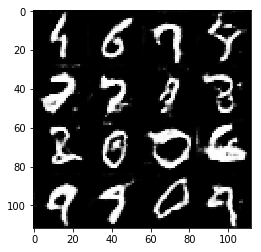

Epoch 1/2... Discriminator Loss: 1.0353... Generator Loss: 0.9069
Epoch 1/2... Discriminator Loss: 0.8305... Generator Loss: 1.0421
Epoch 1/2... Discriminator Loss: 0.8207... Generator Loss: 1.0291
Epoch 1/2... Discriminator Loss: 0.7664... Generator Loss: 1.1402
Epoch 1/2... Discriminator Loss: 0.8907... Generator Loss: 0.8136


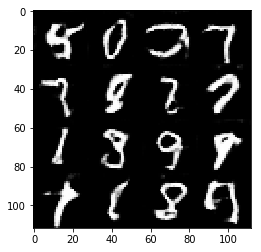

Epoch 1/2... Discriminator Loss: 1.1269... Generator Loss: 0.8062
Epoch 1/2... Discriminator Loss: 1.0339... Generator Loss: 0.5543
Epoch 1/2... Discriminator Loss: 1.1270... Generator Loss: 1.4440
Epoch 1/2... Discriminator Loss: 0.7930... Generator Loss: 1.0280
Epoch 1/2... Discriminator Loss: 0.7189... Generator Loss: 1.7135


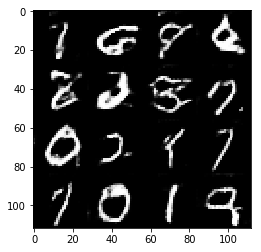

Epoch 1/2... Discriminator Loss: 0.7281... Generator Loss: 1.4258
Epoch 1/2... Discriminator Loss: 1.3916... Generator Loss: 0.5472
Epoch 1/2... Discriminator Loss: 0.6885... Generator Loss: 1.1750
Epoch 1/2... Discriminator Loss: 0.8992... Generator Loss: 2.3601
Epoch 1/2... Discriminator Loss: 0.9816... Generator Loss: 0.9721


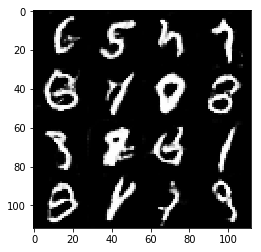

Epoch 1/2... Discriminator Loss: 0.8587... Generator Loss: 1.4440
Epoch 1/2... Discriminator Loss: 0.6234... Generator Loss: 1.5809
Epoch 1/2... Discriminator Loss: 1.4431... Generator Loss: 0.3963
Epoch 1/2... Discriminator Loss: 0.9764... Generator Loss: 0.9681
Epoch 1/2... Discriminator Loss: 0.7065... Generator Loss: 1.1556


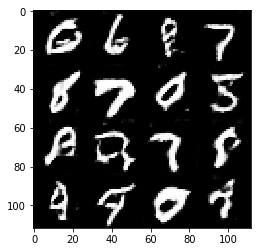

Epoch 1/2... Discriminator Loss: 0.6974... Generator Loss: 1.4889
Epoch 1/2... Discriminator Loss: 0.9350... Generator Loss: 0.9232
Epoch 1/2... Discriminator Loss: 3.4858... Generator Loss: 4.8465
Epoch 1/2... Discriminator Loss: 0.9913... Generator Loss: 0.8052
Epoch 1/2... Discriminator Loss: 0.8209... Generator Loss: 1.2881


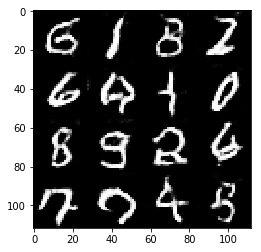

Epoch 1/2... Discriminator Loss: 0.7321... Generator Loss: 1.5052
Epoch 1/2... Discriminator Loss: 0.9132... Generator Loss: 0.8147
Epoch 1/2... Discriminator Loss: 1.9755... Generator Loss: 0.2795
Epoch 1/2... Discriminator Loss: 0.9954... Generator Loss: 0.8534
Epoch 1/2... Discriminator Loss: 0.6952... Generator Loss: 2.3557


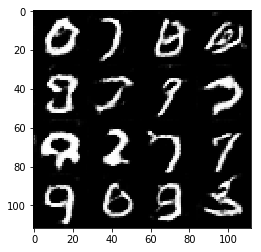

Epoch 1/2... Discriminator Loss: 0.7812... Generator Loss: 0.9556
Epoch 1/2... Discriminator Loss: 1.2474... Generator Loss: 0.5775
Epoch 1/2... Discriminator Loss: 0.8073... Generator Loss: 1.6527
Epoch 1/2... Discriminator Loss: 0.7588... Generator Loss: 1.5359
Epoch 1/2... Discriminator Loss: 1.0331... Generator Loss: 1.1166


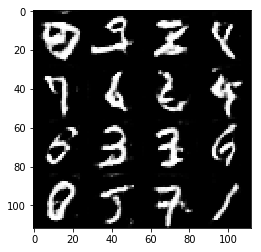

Epoch 1/2... Discriminator Loss: 0.5496... Generator Loss: 1.5195
Epoch 1/2... Discriminator Loss: 0.5320... Generator Loss: 1.8170
Epoch 1/2... Discriminator Loss: 0.7606... Generator Loss: 1.4478
Epoch 1/2... Discriminator Loss: 0.7367... Generator Loss: 1.4820
Epoch 1/2... Discriminator Loss: 1.3041... Generator Loss: 0.5760


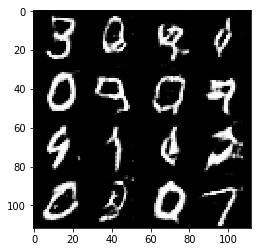

Epoch 1/2... Discriminator Loss: 0.8017... Generator Loss: 1.0102
Epoch 1/2... Discriminator Loss: 0.5593... Generator Loss: 1.3882
Epoch 1/2... Discriminator Loss: 0.5307... Generator Loss: 1.8071
Epoch 1/2... Discriminator Loss: 0.8128... Generator Loss: 0.8518
Epoch 1/2... Discriminator Loss: 0.6795... Generator Loss: 0.9223


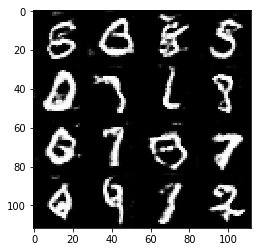

Epoch 1/2... Discriminator Loss: 1.4437... Generator Loss: 0.5451
Epoch 1/2... Discriminator Loss: 0.6275... Generator Loss: 1.8591
Epoch 1/2... Discriminator Loss: 0.6435... Generator Loss: 1.5840
Epoch 1/2... Discriminator Loss: 0.9513... Generator Loss: 0.6239
Epoch 1/2... Discriminator Loss: 0.8539... Generator Loss: 1.2047


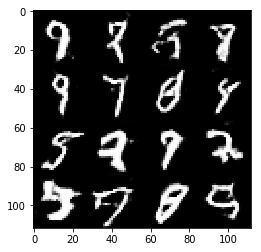

Epoch 1/2... Discriminator Loss: 0.9109... Generator Loss: 1.5951
Epoch 1/2... Discriminator Loss: 1.0026... Generator Loss: 1.7453
Epoch 1/2... Discriminator Loss: 0.9413... Generator Loss: 1.0274
Epoch 1/2... Discriminator Loss: 0.7124... Generator Loss: 1.5166
Epoch 1/2... Discriminator Loss: 0.6096... Generator Loss: 1.9981


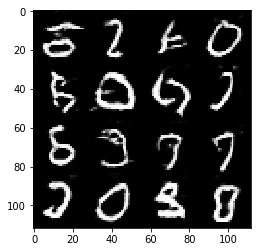

Epoch 1/2... Discriminator Loss: 0.9826... Generator Loss: 0.8441
Epoch 1/2... Discriminator Loss: 0.7525... Generator Loss: 0.9084
Epoch 1/2... Discriminator Loss: 1.0627... Generator Loss: 0.7920
Epoch 1/2... Discriminator Loss: 0.7515... Generator Loss: 0.9866
Epoch 1/2... Discriminator Loss: 1.3631... Generator Loss: 0.3897


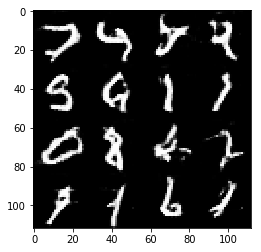

Epoch 1/2... Discriminator Loss: 0.5925... Generator Loss: 1.6219
Epoch 1/2... Discriminator Loss: 1.1010... Generator Loss: 0.6320
Epoch 1/2... Discriminator Loss: 0.8880... Generator Loss: 1.3738
Epoch 1/2... Discriminator Loss: 0.9917... Generator Loss: 0.8329
Epoch 1/2... Discriminator Loss: 0.9218... Generator Loss: 0.9730


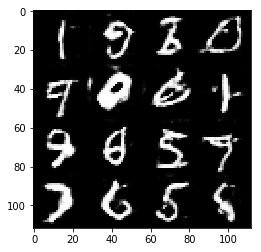

Epoch 1/2... Discriminator Loss: 0.6553... Generator Loss: 1.3255
Epoch 1/2... Discriminator Loss: 0.6369... Generator Loss: 1.1986
Epoch 1/2... Discriminator Loss: 0.6599... Generator Loss: 1.1909
Epoch 1/2... Discriminator Loss: 0.5705... Generator Loss: 1.3185
Epoch 1/2... Discriminator Loss: 0.7974... Generator Loss: 1.2683


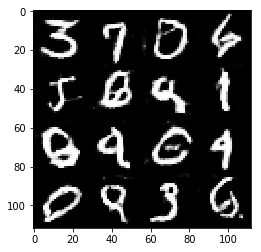

Epoch 1/2... Discriminator Loss: 0.6427... Generator Loss: 1.9730
Epoch 1/2... Discriminator Loss: 0.7233... Generator Loss: 1.0837
Epoch 1/2... Discriminator Loss: 0.8401... Generator Loss: 0.9967
Epoch 1/2... Discriminator Loss: 0.6628... Generator Loss: 2.0530
Epoch 1/2... Discriminator Loss: 0.6872... Generator Loss: 1.5123


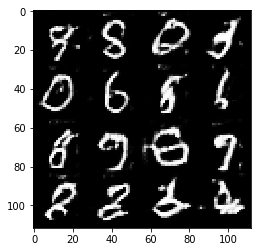

Epoch 1/2... Discriminator Loss: 0.9020... Generator Loss: 0.9123
Epoch 1/2... Discriminator Loss: 1.1325... Generator Loss: 0.5222
Epoch 1/2... Discriminator Loss: 0.6217... Generator Loss: 1.5210
Epoch 1/2... Discriminator Loss: 1.2904... Generator Loss: 0.7004
Epoch 1/2... Discriminator Loss: 0.5677... Generator Loss: 2.1974


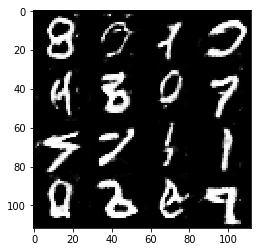

Epoch 1/2... Discriminator Loss: 1.2239... Generator Loss: 0.5065
Epoch 1/2... Discriminator Loss: 0.5030... Generator Loss: 1.8275
Epoch 1/2... Discriminator Loss: 0.7958... Generator Loss: 1.5893
Epoch 1/2... Discriminator Loss: 0.6867... Generator Loss: 1.6155
Epoch 1/2... Discriminator Loss: 0.3814... Generator Loss: 2.1445


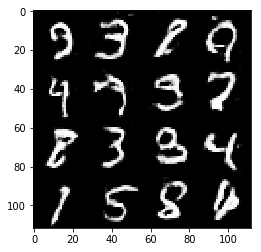

Epoch 1/2... Discriminator Loss: 0.5751... Generator Loss: 2.0583
Epoch 1/2... Discriminator Loss: 0.7724... Generator Loss: 1.0611
Epoch 1/2... Discriminator Loss: 1.6435... Generator Loss: 0.4730
Epoch 1/2... Discriminator Loss: 0.6213... Generator Loss: 1.0467
Epoch 1/2... Discriminator Loss: 0.8280... Generator Loss: 0.8891


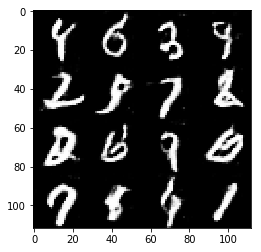

Epoch 1/2... Discriminator Loss: 0.8260... Generator Loss: 1.2357
Epoch 1/2... Discriminator Loss: 0.6537... Generator Loss: 1.2709
Epoch 1/2... Discriminator Loss: 0.6592... Generator Loss: 2.3502
Epoch 1/2... Discriminator Loss: 0.5000... Generator Loss: 1.2794
Epoch 1/2... Discriminator Loss: 0.5293... Generator Loss: 1.9470


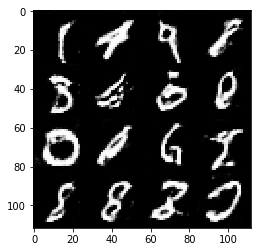

Epoch 1/2... Discriminator Loss: 0.7301... Generator Loss: 0.9054
Epoch 1/2... Discriminator Loss: 0.6883... Generator Loss: 1.0550
Epoch 1/2... Discriminator Loss: 1.0175... Generator Loss: 0.7179
Epoch 1/2... Discriminator Loss: 0.9440... Generator Loss: 1.0061
Epoch 1/2... Discriminator Loss: 0.7394... Generator Loss: 1.0600


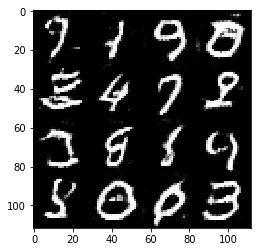

Epoch 1/2... Discriminator Loss: 0.5394... Generator Loss: 1.4597
Epoch 1/2... Discriminator Loss: 0.5291... Generator Loss: 2.1686
Epoch 1/2... Discriminator Loss: 0.4409... Generator Loss: 2.3830
Epoch 1/2... Discriminator Loss: 0.4393... Generator Loss: 2.2029
Epoch 1/2... Discriminator Loss: 0.6581... Generator Loss: 1.4715


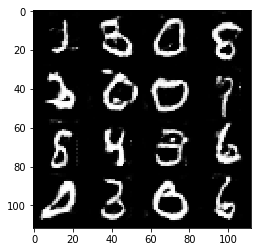

Epoch 1/2... Discriminator Loss: 0.7026... Generator Loss: 1.4779
Epoch 1/2... Discriminator Loss: 0.7228... Generator Loss: 1.3192
Epoch 1/2... Discriminator Loss: 0.5187... Generator Loss: 1.5842
Epoch 1/2... Discriminator Loss: 0.4274... Generator Loss: 1.6160
Epoch 1/2... Discriminator Loss: 1.7120... Generator Loss: 0.3511


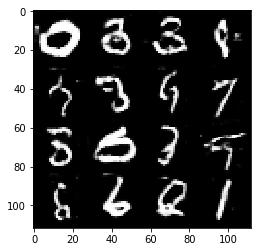

Epoch 1/2... Discriminator Loss: 0.6153... Generator Loss: 1.4189
Epoch 1/2... Discriminator Loss: 0.6962... Generator Loss: 1.6602
Epoch 1/2... Discriminator Loss: 0.6524... Generator Loss: 1.2331
Epoch 1/2... Discriminator Loss: 0.5732... Generator Loss: 2.0167
Epoch 1/2... Discriminator Loss: 0.7588... Generator Loss: 1.7723


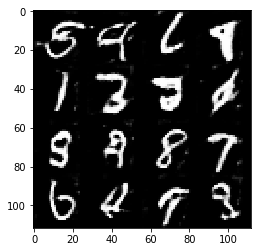

Epoch 1/2... Discriminator Loss: 0.5079... Generator Loss: 2.0833
Epoch 1/2... Discriminator Loss: 1.1125... Generator Loss: 0.9008
Epoch 1/2... Discriminator Loss: 0.7760... Generator Loss: 1.3681
Epoch 1/2... Discriminator Loss: 1.1816... Generator Loss: 0.4698
Epoch 1/2... Discriminator Loss: 0.4754... Generator Loss: 1.5899


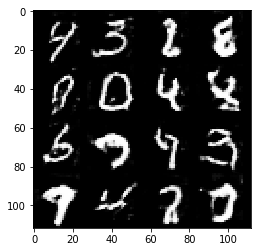

Epoch 1/2... Discriminator Loss: 0.4195... Generator Loss: 1.3442
Epoch 1/2... Discriminator Loss: 0.5466... Generator Loss: 1.6666
Epoch 1/2... Discriminator Loss: 0.6584... Generator Loss: 1.1587
Epoch 1/2... Discriminator Loss: 0.7100... Generator Loss: 1.3908
Epoch 1/2... Discriminator Loss: 0.5700... Generator Loss: 1.4535


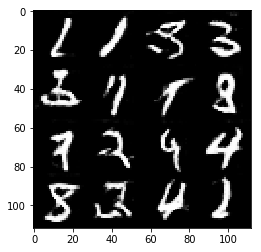

Epoch 1/2... Discriminator Loss: 0.5107... Generator Loss: 1.8532
Epoch 1/2... Discriminator Loss: 0.7991... Generator Loss: 1.1999
Epoch 1/2... Discriminator Loss: 0.6886... Generator Loss: 1.5825
Epoch 1/2... Discriminator Loss: 1.1264... Generator Loss: 1.2126
Epoch 1/2... Discriminator Loss: 0.5303... Generator Loss: 1.4679


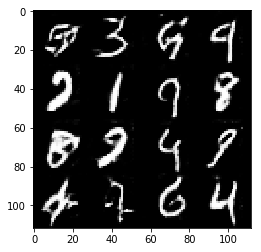

Epoch 1/2... Discriminator Loss: 0.7873... Generator Loss: 1.1031
Epoch 1/2... Discriminator Loss: 0.8371... Generator Loss: 1.1269
Epoch 1/2... Discriminator Loss: 0.8511... Generator Loss: 1.7346
Epoch 1/2... Discriminator Loss: 0.8161... Generator Loss: 2.4244
Epoch 1/2... Discriminator Loss: 0.8767... Generator Loss: 1.4020


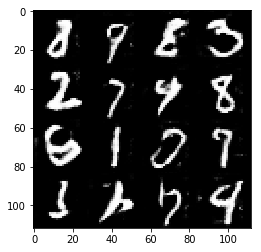

Epoch 1/2... Discriminator Loss: 0.5507... Generator Loss: 1.9522
Epoch 1/2... Discriminator Loss: 0.8461... Generator Loss: 1.6228
Epoch 1/2... Discriminator Loss: 0.6666... Generator Loss: 1.3779
Epoch 1/2... Discriminator Loss: 0.7138... Generator Loss: 1.4610
Epoch 1/2... Discriminator Loss: 0.9862... Generator Loss: 0.6881


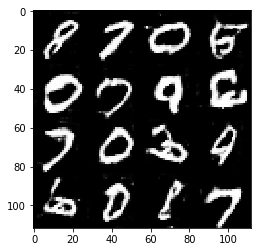

Epoch 1/2... Discriminator Loss: 0.7097... Generator Loss: 1.7495
Epoch 1/2... Discriminator Loss: 0.7025... Generator Loss: 1.2075
Epoch 1/2... Discriminator Loss: 0.8048... Generator Loss: 1.0910
Epoch 1/2... Discriminator Loss: 0.4334... Generator Loss: 1.6035
Epoch 1/2... Discriminator Loss: 0.7002... Generator Loss: 0.6366


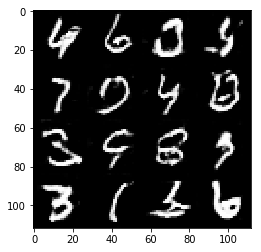

Epoch 1/2... Discriminator Loss: 0.4374... Generator Loss: 1.7448
Epoch 1/2... Discriminator Loss: 0.5289... Generator Loss: 1.8741
Epoch 1/2... Discriminator Loss: 1.1124... Generator Loss: 0.6239
Epoch 1/2... Discriminator Loss: 1.2432... Generator Loss: 0.5664
Epoch 1/2... Discriminator Loss: 0.4404... Generator Loss: 1.9867


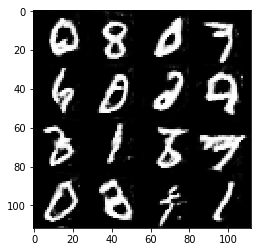

Epoch 1/2... Discriminator Loss: 0.5402... Generator Loss: 1.5503


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 2.1696... Generator Loss: 0.2313
Epoch 0/1... Discriminator Loss: 1.0628... Generator Loss: 1.3717
Epoch 0/1... Discriminator Loss: 1.3120... Generator Loss: 0.5544
Epoch 0/1... Discriminator Loss: 1.0893... Generator Loss: 0.8604


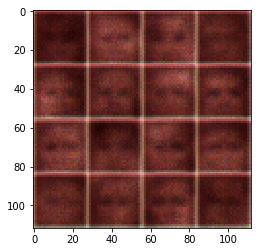

Epoch 0/1... Discriminator Loss: 1.3153... Generator Loss: 0.5013
Epoch 0/1... Discriminator Loss: 0.9842... Generator Loss: 0.8474
Epoch 0/1... Discriminator Loss: 0.2927... Generator Loss: 2.8460
Epoch 0/1... Discriminator Loss: 2.7674... Generator Loss: 0.1186
Epoch 0/1... Discriminator Loss: 0.3777... Generator Loss: 2.5495


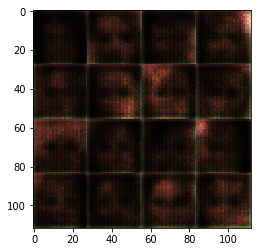

Epoch 0/1... Discriminator Loss: 0.3147... Generator Loss: 2.4292
Epoch 0/1... Discriminator Loss: 0.6505... Generator Loss: 1.4752
Epoch 0/1... Discriminator Loss: 0.6736... Generator Loss: 1.6063
Epoch 0/1... Discriminator Loss: 0.6565... Generator Loss: 3.7537
Epoch 0/1... Discriminator Loss: 1.8301... Generator Loss: 0.3122


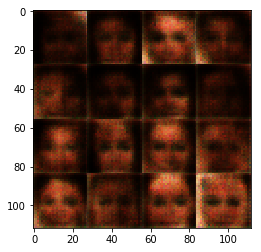

Epoch 0/1... Discriminator Loss: 0.9973... Generator Loss: 3.0052
Epoch 0/1... Discriminator Loss: 0.7407... Generator Loss: 0.9786
Epoch 0/1... Discriminator Loss: 0.3189... Generator Loss: 2.0775
Epoch 0/1... Discriminator Loss: 0.6791... Generator Loss: 3.4003
Epoch 0/1... Discriminator Loss: 1.2344... Generator Loss: 5.9283


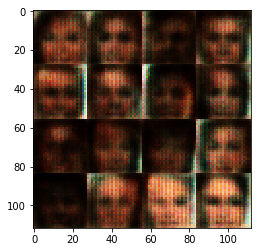

Epoch 0/1... Discriminator Loss: 0.3413... Generator Loss: 3.4535
Epoch 0/1... Discriminator Loss: 0.3601... Generator Loss: 2.7302
Epoch 0/1... Discriminator Loss: 0.2463... Generator Loss: 7.9654
Epoch 0/1... Discriminator Loss: 0.6271... Generator Loss: 2.4783
Epoch 0/1... Discriminator Loss: 0.4099... Generator Loss: 1.9650


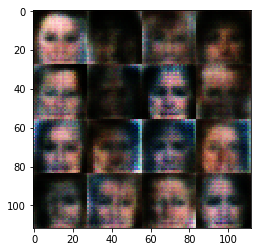

Epoch 0/1... Discriminator Loss: 1.5871... Generator Loss: 0.3305
Epoch 0/1... Discriminator Loss: 2.8255... Generator Loss: 0.1263
Epoch 0/1... Discriminator Loss: 2.0282... Generator Loss: 2.9135
Epoch 0/1... Discriminator Loss: 0.3210... Generator Loss: 2.8008
Epoch 0/1... Discriminator Loss: 0.4794... Generator Loss: 2.2917


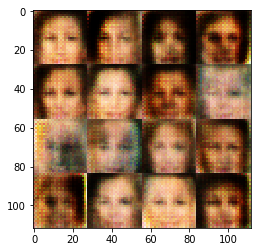

Epoch 0/1... Discriminator Loss: 0.3115... Generator Loss: 3.4300
Epoch 0/1... Discriminator Loss: 2.0110... Generator Loss: 0.2082
Epoch 0/1... Discriminator Loss: 0.1596... Generator Loss: 3.4204
Epoch 0/1... Discriminator Loss: 1.0716... Generator Loss: 1.0245
Epoch 0/1... Discriminator Loss: 1.3909... Generator Loss: 0.6532


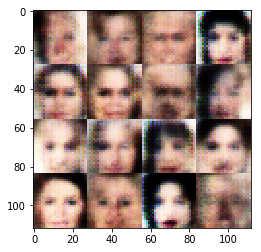

Epoch 0/1... Discriminator Loss: 0.6889... Generator Loss: 1.3737
Epoch 0/1... Discriminator Loss: 0.7420... Generator Loss: 1.4010
Epoch 0/1... Discriminator Loss: 2.0499... Generator Loss: 0.3087
Epoch 0/1... Discriminator Loss: 1.0036... Generator Loss: 0.8433
Epoch 0/1... Discriminator Loss: 1.1121... Generator Loss: 0.6838


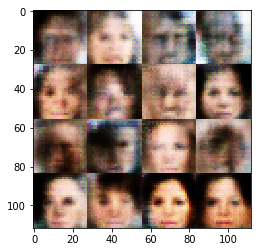

Epoch 0/1... Discriminator Loss: 1.8515... Generator Loss: 0.3230
Epoch 0/1... Discriminator Loss: 0.5654... Generator Loss: 1.8310
Epoch 0/1... Discriminator Loss: 0.3458... Generator Loss: 3.3170
Epoch 0/1... Discriminator Loss: 1.2165... Generator Loss: 0.7699
Epoch 0/1... Discriminator Loss: 0.6693... Generator Loss: 1.4792


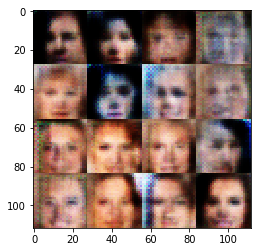

Epoch 0/1... Discriminator Loss: 0.5811... Generator Loss: 1.4187
Epoch 0/1... Discriminator Loss: 0.6564... Generator Loss: 1.5619
Epoch 0/1... Discriminator Loss: 1.7080... Generator Loss: 1.0357
Epoch 0/1... Discriminator Loss: 1.3234... Generator Loss: 0.5687
Epoch 0/1... Discriminator Loss: 0.9123... Generator Loss: 1.4803


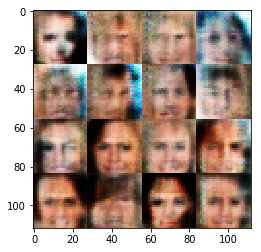

Epoch 0/1... Discriminator Loss: 0.5303... Generator Loss: 1.5595
Epoch 0/1... Discriminator Loss: 2.1010... Generator Loss: 0.2889
Epoch 0/1... Discriminator Loss: 0.3717... Generator Loss: 5.6016
Epoch 0/1... Discriminator Loss: 2.1106... Generator Loss: 0.5600
Epoch 0/1... Discriminator Loss: 0.9511... Generator Loss: 1.1817


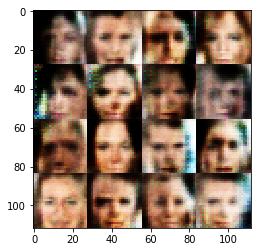

Epoch 0/1... Discriminator Loss: 0.5386... Generator Loss: 1.7099
Epoch 0/1... Discriminator Loss: 0.2954... Generator Loss: 4.1104
Epoch 0/1... Discriminator Loss: 0.2575... Generator Loss: 2.4686
Epoch 0/1... Discriminator Loss: 2.4365... Generator Loss: 1.2576
Epoch 0/1... Discriminator Loss: 0.4977... Generator Loss: 2.5599


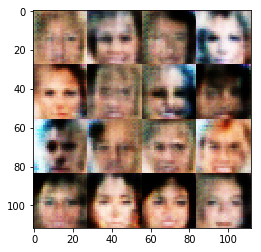

Epoch 0/1... Discriminator Loss: 1.1377... Generator Loss: 0.8249
Epoch 0/1... Discriminator Loss: 0.4898... Generator Loss: 2.0434
Epoch 0/1... Discriminator Loss: 0.3580... Generator Loss: 2.1045
Epoch 0/1... Discriminator Loss: 3.2731... Generator Loss: 3.8440
Epoch 0/1... Discriminator Loss: 1.1450... Generator Loss: 5.3258


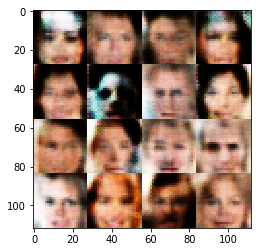

Epoch 0/1... Discriminator Loss: 1.7489... Generator Loss: 0.3483
Epoch 0/1... Discriminator Loss: 0.5080... Generator Loss: 2.4248
Epoch 0/1... Discriminator Loss: 0.4021... Generator Loss: 6.1691
Epoch 0/1... Discriminator Loss: 0.8100... Generator Loss: 1.8413
Epoch 0/1... Discriminator Loss: 0.5960... Generator Loss: 2.6621


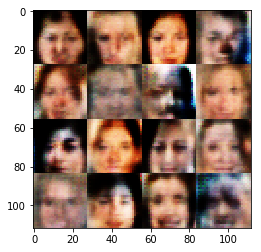

Epoch 0/1... Discriminator Loss: 0.4108... Generator Loss: 1.9708
Epoch 0/1... Discriminator Loss: 1.7677... Generator Loss: 0.3186
Epoch 0/1... Discriminator Loss: 0.6636... Generator Loss: 1.1980
Epoch 0/1... Discriminator Loss: 0.3405... Generator Loss: 1.7895
Epoch 0/1... Discriminator Loss: 3.6396... Generator Loss: 2.4711


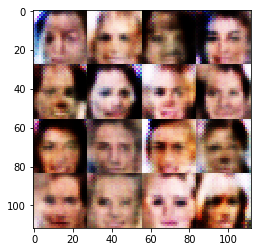

Epoch 0/1... Discriminator Loss: 0.3789... Generator Loss: 1.8993
Epoch 0/1... Discriminator Loss: 0.6767... Generator Loss: 2.0878
Epoch 0/1... Discriminator Loss: 0.5723... Generator Loss: 1.6051
Epoch 0/1... Discriminator Loss: 1.9272... Generator Loss: 0.3783
Epoch 0/1... Discriminator Loss: 0.6578... Generator Loss: 1.3063


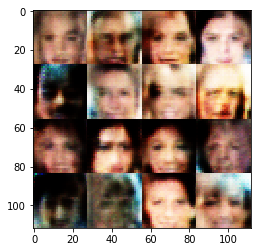

Epoch 0/1... Discriminator Loss: 0.6648... Generator Loss: 1.3684
Epoch 0/1... Discriminator Loss: 0.6552... Generator Loss: 1.2420
Epoch 0/1... Discriminator Loss: 0.6800... Generator Loss: 1.9383
Epoch 0/1... Discriminator Loss: 0.4654... Generator Loss: 1.7557
Epoch 0/1... Discriminator Loss: 0.6048... Generator Loss: 1.1552


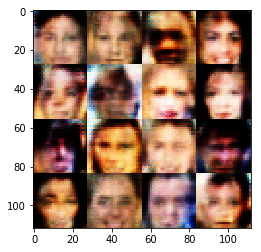

Epoch 0/1... Discriminator Loss: 0.3689... Generator Loss: 1.6568
Epoch 0/1... Discriminator Loss: 1.7463... Generator Loss: 0.2178
Epoch 0/1... Discriminator Loss: 2.1792... Generator Loss: 0.4718
Epoch 0/1... Discriminator Loss: 1.1216... Generator Loss: 1.0424
Epoch 0/1... Discriminator Loss: 0.7842... Generator Loss: 1.4928


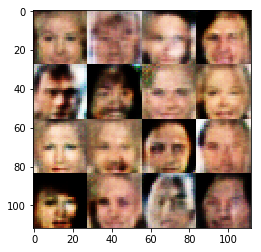

Epoch 0/1... Discriminator Loss: 1.1110... Generator Loss: 0.7409
Epoch 0/1... Discriminator Loss: 0.6049... Generator Loss: 1.6237
Epoch 0/1... Discriminator Loss: 0.2181... Generator Loss: 3.4214
Epoch 0/1... Discriminator Loss: 1.3078... Generator Loss: 0.7669
Epoch 0/1... Discriminator Loss: 0.3196... Generator Loss: 4.4085


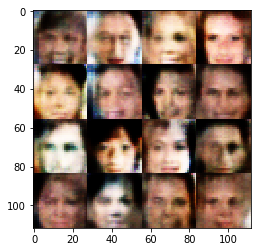

Epoch 0/1... Discriminator Loss: 0.7344... Generator Loss: 0.8793
Epoch 0/1... Discriminator Loss: 1.0536... Generator Loss: 2.3081
Epoch 0/1... Discriminator Loss: 1.8363... Generator Loss: 0.2417
Epoch 0/1... Discriminator Loss: 0.8809... Generator Loss: 1.2291
Epoch 0/1... Discriminator Loss: 0.5131... Generator Loss: 1.7741


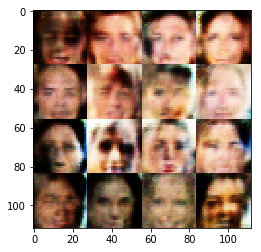

Epoch 0/1... Discriminator Loss: 0.7573... Generator Loss: 2.0871
Epoch 0/1... Discriminator Loss: 0.2720... Generator Loss: 3.3395
Epoch 0/1... Discriminator Loss: 0.5032... Generator Loss: 1.5796
Epoch 0/1... Discriminator Loss: 0.8964... Generator Loss: 1.6913
Epoch 0/1... Discriminator Loss: 0.2085... Generator Loss: 2.7747


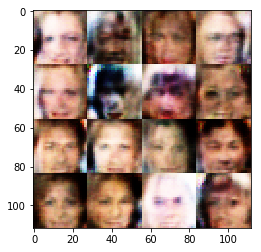

Epoch 0/1... Discriminator Loss: 0.6150... Generator Loss: 3.1286
Epoch 0/1... Discriminator Loss: 0.4137... Generator Loss: 2.2800
Epoch 0/1... Discriminator Loss: 0.3418... Generator Loss: 2.4846
Epoch 0/1... Discriminator Loss: 1.0509... Generator Loss: 1.2220
Epoch 0/1... Discriminator Loss: 0.4163... Generator Loss: 3.1325


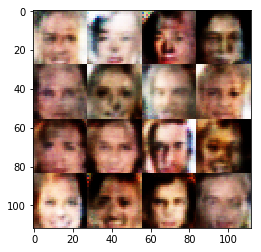

Epoch 0/1... Discriminator Loss: 0.6270... Generator Loss: 1.2660
Epoch 0/1... Discriminator Loss: 0.1986... Generator Loss: 3.1921
Epoch 0/1... Discriminator Loss: 0.2680... Generator Loss: 2.6766
Epoch 0/1... Discriminator Loss: 0.7587... Generator Loss: 2.6305
Epoch 0/1... Discriminator Loss: 0.5086... Generator Loss: 1.3463


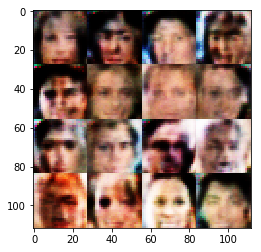

Epoch 0/1... Discriminator Loss: 0.3226... Generator Loss: 3.4226
Epoch 0/1... Discriminator Loss: 0.5168... Generator Loss: 3.9495
Epoch 0/1... Discriminator Loss: 1.5391... Generator Loss: 0.6181
Epoch 0/1... Discriminator Loss: 0.8048... Generator Loss: 1.4298
Epoch 0/1... Discriminator Loss: 0.9098... Generator Loss: 1.3489


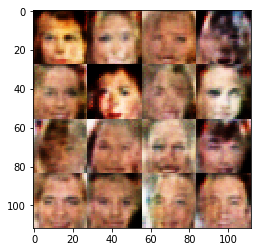

Epoch 0/1... Discriminator Loss: 1.7755... Generator Loss: 0.4991
Epoch 0/1... Discriminator Loss: 1.4713... Generator Loss: 0.5605
Epoch 0/1... Discriminator Loss: 0.3283... Generator Loss: 3.1571
Epoch 0/1... Discriminator Loss: 1.2387... Generator Loss: 3.3045
Epoch 0/1... Discriminator Loss: 1.1759... Generator Loss: 1.3554


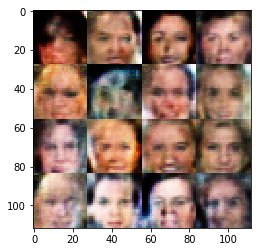

Epoch 0/1... Discriminator Loss: 0.9183... Generator Loss: 2.7775
Epoch 0/1... Discriminator Loss: 0.9976... Generator Loss: 2.1274
Epoch 0/1... Discriminator Loss: 1.3189... Generator Loss: 1.0059
Epoch 0/1... Discriminator Loss: 0.5633... Generator Loss: 2.6675
Epoch 0/1... Discriminator Loss: 0.4233... Generator Loss: 2.2381


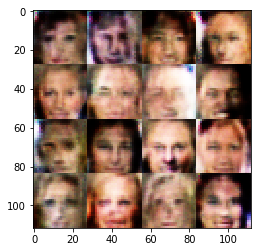

Epoch 0/1... Discriminator Loss: 0.5102... Generator Loss: 1.6557
Epoch 0/1... Discriminator Loss: 1.9393... Generator Loss: 0.2774
Epoch 0/1... Discriminator Loss: 0.3767... Generator Loss: 4.8345
Epoch 0/1... Discriminator Loss: 0.6494... Generator Loss: 1.1894
Epoch 0/1... Discriminator Loss: 0.1485... Generator Loss: 4.2178


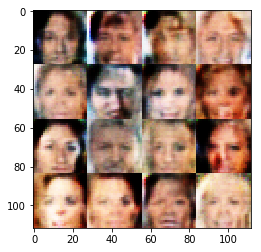

Epoch 0/1... Discriminator Loss: 1.2216... Generator Loss: 0.4837
Epoch 0/1... Discriminator Loss: 1.5471... Generator Loss: 0.3929
Epoch 0/1... Discriminator Loss: 0.8072... Generator Loss: 1.0940
Epoch 0/1... Discriminator Loss: 1.7998... Generator Loss: 4.2294
Epoch 0/1... Discriminator Loss: 0.5393... Generator Loss: 4.5749


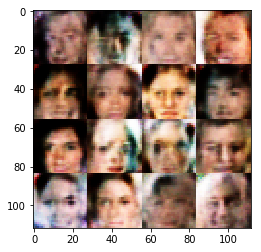

Epoch 0/1... Discriminator Loss: 1.2089... Generator Loss: 0.6174
Epoch 0/1... Discriminator Loss: 0.8473... Generator Loss: 0.8566
Epoch 0/1... Discriminator Loss: 0.2532... Generator Loss: 2.2683
Epoch 0/1... Discriminator Loss: 0.5760... Generator Loss: 1.2057
Epoch 0/1... Discriminator Loss: 1.4831... Generator Loss: 0.9775


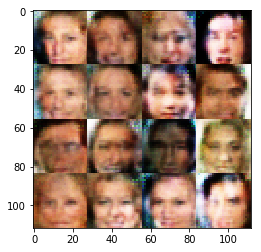

Epoch 0/1... Discriminator Loss: 0.9939... Generator Loss: 0.7678
Epoch 0/1... Discriminator Loss: 0.7240... Generator Loss: 1.3285
Epoch 0/1... Discriminator Loss: 0.8292... Generator Loss: 0.8904
Epoch 0/1... Discriminator Loss: 0.5315... Generator Loss: 2.0654
Epoch 0/1... Discriminator Loss: 0.4439... Generator Loss: 1.3955


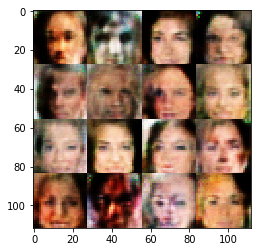

Epoch 0/1... Discriminator Loss: 0.9131... Generator Loss: 1.1652
Epoch 0/1... Discriminator Loss: 0.8563... Generator Loss: 2.6169
Epoch 0/1... Discriminator Loss: 1.0724... Generator Loss: 1.7950
Epoch 0/1... Discriminator Loss: 1.4067... Generator Loss: 0.6831
Epoch 0/1... Discriminator Loss: 0.3772... Generator Loss: 1.8272


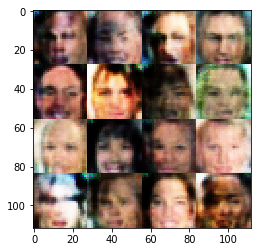

Epoch 0/1... Discriminator Loss: 0.1531... Generator Loss: 3.8029
Epoch 0/1... Discriminator Loss: 0.3306... Generator Loss: 2.7994
Epoch 0/1... Discriminator Loss: 0.8081... Generator Loss: 2.0624
Epoch 0/1... Discriminator Loss: 1.5454... Generator Loss: 1.2804
Epoch 0/1... Discriminator Loss: 0.6478... Generator Loss: 1.7661


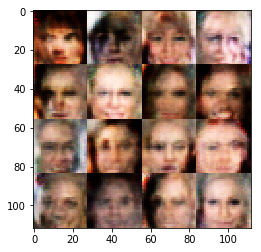

Epoch 0/1... Discriminator Loss: 0.6354... Generator Loss: 2.9387
Epoch 0/1... Discriminator Loss: 0.5646... Generator Loss: 1.6274
Epoch 0/1... Discriminator Loss: 0.6525... Generator Loss: 1.3078
Epoch 0/1... Discriminator Loss: 1.0415... Generator Loss: 0.9457
Epoch 0/1... Discriminator Loss: 1.3068... Generator Loss: 1.6402


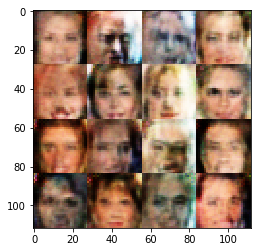

Epoch 0/1... Discriminator Loss: 1.2643... Generator Loss: 0.8579
Epoch 0/1... Discriminator Loss: 1.0980... Generator Loss: 1.4577
Epoch 0/1... Discriminator Loss: 2.7387... Generator Loss: 2.8349
Epoch 0/1... Discriminator Loss: 1.7225... Generator Loss: 0.4916
Epoch 0/1... Discriminator Loss: 0.6736... Generator Loss: 1.3129


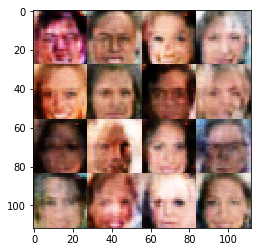

Epoch 0/1... Discriminator Loss: 0.7371... Generator Loss: 1.2012
Epoch 0/1... Discriminator Loss: 0.4558... Generator Loss: 2.8300
Epoch 0/1... Discriminator Loss: 0.6584... Generator Loss: 0.8546
Epoch 0/1... Discriminator Loss: 0.5768... Generator Loss: 1.4557
Epoch 0/1... Discriminator Loss: 0.4204... Generator Loss: 2.9793


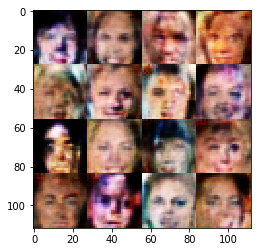

Epoch 0/1... Discriminator Loss: 0.6773... Generator Loss: 1.0687
Epoch 0/1... Discriminator Loss: 0.9073... Generator Loss: 1.0691
Epoch 0/1... Discriminator Loss: 0.5149... Generator Loss: 1.9201
Epoch 0/1... Discriminator Loss: 0.7361... Generator Loss: 1.0050
Epoch 0/1... Discriminator Loss: 0.5674... Generator Loss: 1.8779


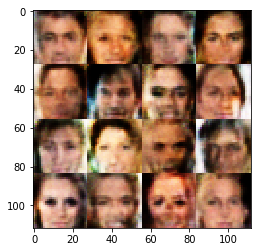

Epoch 0/1... Discriminator Loss: 0.5750... Generator Loss: 2.4560
Epoch 0/1... Discriminator Loss: 1.0833... Generator Loss: 0.6451
Epoch 0/1... Discriminator Loss: 1.6511... Generator Loss: 0.5700
Epoch 0/1... Discriminator Loss: 0.6743... Generator Loss: 3.8951
Epoch 0/1... Discriminator Loss: 1.1930... Generator Loss: 0.5399


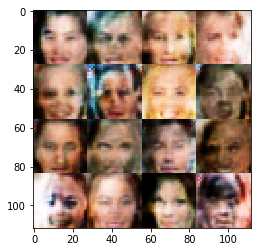

Epoch 0/1... Discriminator Loss: 0.2445... Generator Loss: 2.7655
Epoch 0/1... Discriminator Loss: 0.8280... Generator Loss: 1.5637
Epoch 0/1... Discriminator Loss: 0.7331... Generator Loss: 1.0084
Epoch 0/1... Discriminator Loss: 0.2327... Generator Loss: 2.1445
Epoch 0/1... Discriminator Loss: 2.1423... Generator Loss: 0.1991


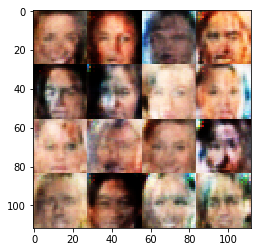

Epoch 0/1... Discriminator Loss: 0.5924... Generator Loss: 1.1084
Epoch 0/1... Discriminator Loss: 0.2297... Generator Loss: 2.9436
Epoch 0/1... Discriminator Loss: 0.6044... Generator Loss: 1.5215
Epoch 0/1... Discriminator Loss: 0.3807... Generator Loss: 1.7988
Epoch 0/1... Discriminator Loss: 1.2830... Generator Loss: 2.0341


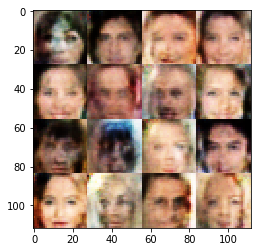

Epoch 0/1... Discriminator Loss: 1.4042... Generator Loss: 1.8655
Epoch 0/1... Discriminator Loss: 0.9274... Generator Loss: 0.8673
Epoch 0/1... Discriminator Loss: 0.1799... Generator Loss: 2.4043
Epoch 0/1... Discriminator Loss: 0.9903... Generator Loss: 2.0556
Epoch 0/1... Discriminator Loss: 0.5145... Generator Loss: 1.5785


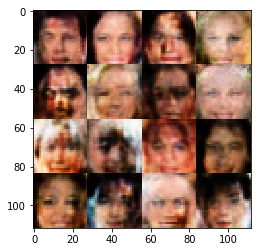

Epoch 0/1... Discriminator Loss: 2.1710... Generator Loss: 3.4857
Epoch 0/1... Discriminator Loss: 1.4957... Generator Loss: 0.6203
Epoch 0/1... Discriminator Loss: 1.0642... Generator Loss: 1.3328
Epoch 0/1... Discriminator Loss: 0.5461... Generator Loss: 2.4803
Epoch 0/1... Discriminator Loss: 0.7202... Generator Loss: 1.1269


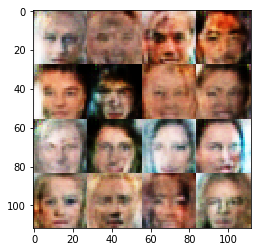

Epoch 0/1... Discriminator Loss: 0.2483... Generator Loss: 3.1540
Epoch 0/1... Discriminator Loss: 0.8268... Generator Loss: 2.1803
Epoch 0/1... Discriminator Loss: 0.5151... Generator Loss: 3.3244
Epoch 0/1... Discriminator Loss: 0.4843... Generator Loss: 4.1944
Epoch 0/1... Discriminator Loss: 0.2988... Generator Loss: 2.1157


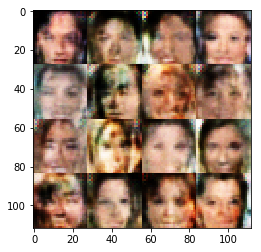

Epoch 0/1... Discriminator Loss: 0.1865... Generator Loss: 4.4812
Epoch 0/1... Discriminator Loss: 0.9063... Generator Loss: 0.9571
Epoch 0/1... Discriminator Loss: 2.0124... Generator Loss: 0.2092
Epoch 0/1... Discriminator Loss: 1.4157... Generator Loss: 0.3480
Epoch 0/1... Discriminator Loss: 0.1871... Generator Loss: 2.6313


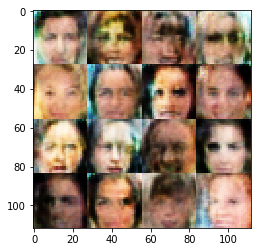

Epoch 0/1... Discriminator Loss: 1.1260... Generator Loss: 0.5417
Epoch 0/1... Discriminator Loss: 0.6983... Generator Loss: 0.9250
Epoch 0/1... Discriminator Loss: 0.7643... Generator Loss: 1.0471
Epoch 0/1... Discriminator Loss: 0.3971... Generator Loss: 2.3152
Epoch 0/1... Discriminator Loss: 1.1064... Generator Loss: 3.3857


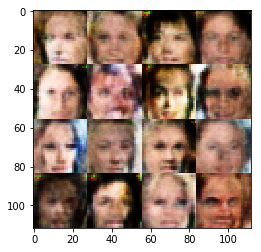

Epoch 0/1... Discriminator Loss: 0.1847... Generator Loss: 4.5747
Epoch 0/1... Discriminator Loss: 0.3031... Generator Loss: 2.4054
Epoch 0/1... Discriminator Loss: 1.2856... Generator Loss: 0.5745
Epoch 0/1... Discriminator Loss: 0.4225... Generator Loss: 2.2375
Epoch 0/1... Discriminator Loss: 0.4089... Generator Loss: 1.5929


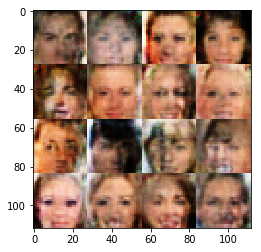

Epoch 0/1... Discriminator Loss: 0.4414... Generator Loss: 2.5845
Epoch 0/1... Discriminator Loss: 0.6710... Generator Loss: 1.2139
Epoch 0/1... Discriminator Loss: 1.2616... Generator Loss: 0.7561
Epoch 0/1... Discriminator Loss: 0.3367... Generator Loss: 1.8179
Epoch 0/1... Discriminator Loss: 0.4723... Generator Loss: 1.4459


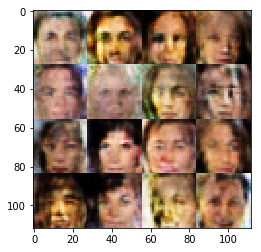

Epoch 0/1... Discriminator Loss: 0.5406... Generator Loss: 2.9185
Epoch 0/1... Discriminator Loss: 0.5520... Generator Loss: 1.3835
Epoch 0/1... Discriminator Loss: 0.3754... Generator Loss: 1.8818
Epoch 0/1... Discriminator Loss: 0.6773... Generator Loss: 1.2644
Epoch 0/1... Discriminator Loss: 0.0925... Generator Loss: 6.4744


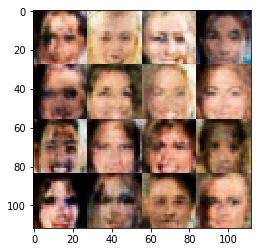

Epoch 0/1... Discriminator Loss: 0.6849... Generator Loss: 2.1989
Epoch 0/1... Discriminator Loss: 0.1807... Generator Loss: 6.2870
Epoch 0/1... Discriminator Loss: 0.4335... Generator Loss: 2.1863
Epoch 0/1... Discriminator Loss: 0.7109... Generator Loss: 1.8837
Epoch 0/1... Discriminator Loss: 0.5908... Generator Loss: 1.3115


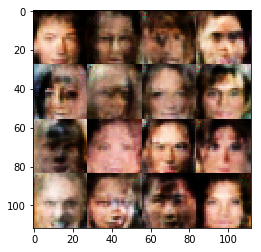

Epoch 0/1... Discriminator Loss: 0.1253... Generator Loss: 3.4669
Epoch 0/1... Discriminator Loss: 0.0861... Generator Loss: 4.6466
Epoch 0/1... Discriminator Loss: 0.7214... Generator Loss: 0.8975
Epoch 0/1... Discriminator Loss: 0.3075... Generator Loss: 2.4890
Epoch 0/1... Discriminator Loss: 0.4643... Generator Loss: 2.7295


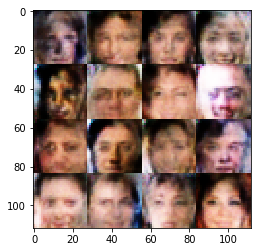

Epoch 0/1... Discriminator Loss: 0.3667... Generator Loss: 2.5344
Epoch 0/1... Discriminator Loss: 1.6317... Generator Loss: 0.4270
Epoch 0/1... Discriminator Loss: 0.3059... Generator Loss: 1.9489
Epoch 0/1... Discriminator Loss: 0.6148... Generator Loss: 1.9923
Epoch 0/1... Discriminator Loss: 0.2175... Generator Loss: 2.9231


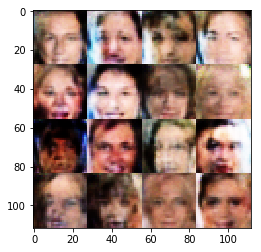

Epoch 0/1... Discriminator Loss: 0.4796... Generator Loss: 1.9640
Epoch 0/1... Discriminator Loss: 0.5022... Generator Loss: 1.1489
Epoch 0/1... Discriminator Loss: 1.6447... Generator Loss: 0.5704
Epoch 0/1... Discriminator Loss: 0.7194... Generator Loss: 1.3120
Epoch 0/1... Discriminator Loss: 0.5402... Generator Loss: 1.9154


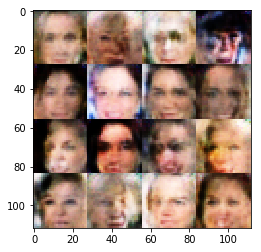

Epoch 0/1... Discriminator Loss: 0.2931... Generator Loss: 2.8730
Epoch 0/1... Discriminator Loss: 1.6300... Generator Loss: 0.3078
Epoch 0/1... Discriminator Loss: 1.4073... Generator Loss: 0.4109
Epoch 0/1... Discriminator Loss: 1.9492... Generator Loss: 0.2203
Epoch 0/1... Discriminator Loss: 2.9759... Generator Loss: 3.0491


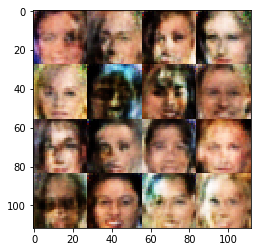

Epoch 0/1... Discriminator Loss: 3.0836... Generator Loss: 0.0771
Epoch 0/1... Discriminator Loss: 0.8149... Generator Loss: 1.6004
Epoch 0/1... Discriminator Loss: 0.3926... Generator Loss: 2.3876
Epoch 0/1... Discriminator Loss: 0.8027... Generator Loss: 0.8691
Epoch 0/1... Discriminator Loss: 0.3337... Generator Loss: 2.1163


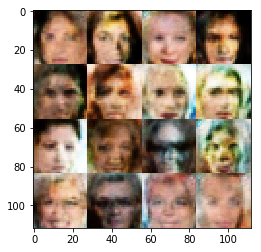

Epoch 0/1... Discriminator Loss: 0.3592... Generator Loss: 2.6216
Epoch 0/1... Discriminator Loss: 1.1790... Generator Loss: 0.4628
Epoch 0/1... Discriminator Loss: 1.1377... Generator Loss: 0.9814
Epoch 0/1... Discriminator Loss: 0.1400... Generator Loss: 3.1727
Epoch 0/1... Discriminator Loss: 0.8423... Generator Loss: 1.4058


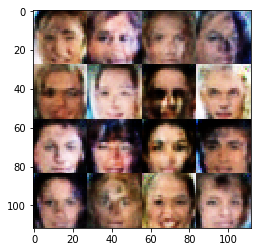

Epoch 0/1... Discriminator Loss: 0.4332... Generator Loss: 1.6447
Epoch 0/1... Discriminator Loss: 1.4386... Generator Loss: 0.7035
Epoch 0/1... Discriminator Loss: 0.3984... Generator Loss: 1.6168
Epoch 0/1... Discriminator Loss: 0.2185... Generator Loss: 3.3429
Epoch 0/1... Discriminator Loss: 0.5672... Generator Loss: 1.3384


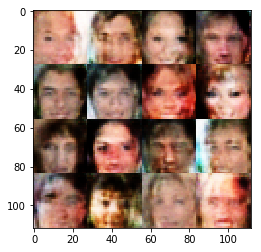

Epoch 0/1... Discriminator Loss: 1.2934... Generator Loss: 0.5186
Epoch 0/1... Discriminator Loss: 0.8032... Generator Loss: 1.1887
Epoch 0/1... Discriminator Loss: 0.9657... Generator Loss: 1.6553
Epoch 0/1... Discriminator Loss: 0.4965... Generator Loss: 2.6105
Epoch 0/1... Discriminator Loss: 0.3654... Generator Loss: 1.9774


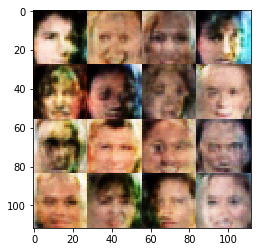

Epoch 0/1... Discriminator Loss: 0.8418... Generator Loss: 1.1598
Epoch 0/1... Discriminator Loss: 0.4068... Generator Loss: 1.3355
Epoch 0/1... Discriminator Loss: 1.8761... Generator Loss: 0.3898
Epoch 0/1... Discriminator Loss: 0.7687... Generator Loss: 2.1081
Epoch 0/1... Discriminator Loss: 1.7742... Generator Loss: 0.3538


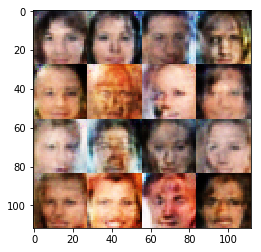

Epoch 0/1... Discriminator Loss: 0.7403... Generator Loss: 1.2923
Epoch 0/1... Discriminator Loss: 1.5426... Generator Loss: 0.3834
Epoch 0/1... Discriminator Loss: 0.1700... Generator Loss: 4.4697
Epoch 0/1... Discriminator Loss: 0.1963... Generator Loss: 3.7450
Epoch 0/1... Discriminator Loss: 1.4338... Generator Loss: 0.4253


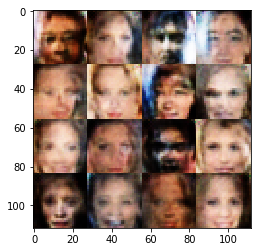

Epoch 0/1... Discriminator Loss: 0.8605... Generator Loss: 1.1689
Epoch 0/1... Discriminator Loss: 1.1315... Generator Loss: 1.7289
Epoch 0/1... Discriminator Loss: 0.9233... Generator Loss: 1.2214
Epoch 0/1... Discriminator Loss: 1.6255... Generator Loss: 0.4350
Epoch 0/1... Discriminator Loss: 0.6700... Generator Loss: 1.6337


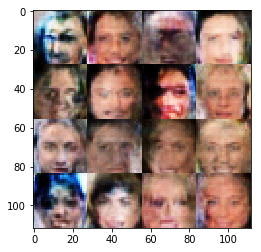

Epoch 0/1... Discriminator Loss: 0.2717... Generator Loss: 2.2361
Epoch 0/1... Discriminator Loss: 0.5624... Generator Loss: 2.2425
Epoch 0/1... Discriminator Loss: 0.3011... Generator Loss: 2.8432
Epoch 0/1... Discriminator Loss: 0.3595... Generator Loss: 2.0304
Epoch 0/1... Discriminator Loss: 0.8039... Generator Loss: 1.0605


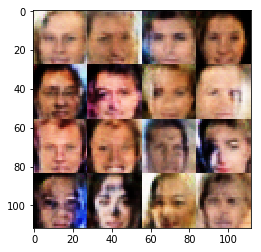

Epoch 0/1... Discriminator Loss: 0.7001... Generator Loss: 1.6552
Epoch 0/1... Discriminator Loss: 0.2335... Generator Loss: 3.2040
Epoch 0/1... Discriminator Loss: 0.4105... Generator Loss: 1.6715
Epoch 0/1... Discriminator Loss: 1.1727... Generator Loss: 0.7633
Epoch 0/1... Discriminator Loss: 0.3328... Generator Loss: 1.8808


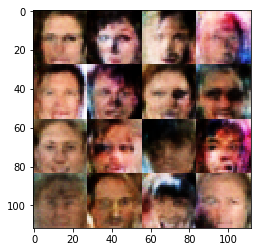

Epoch 0/1... Discriminator Loss: 2.0660... Generator Loss: 0.2507
Epoch 0/1... Discriminator Loss: 1.1452... Generator Loss: 0.8405
Epoch 0/1... Discriminator Loss: 1.6929... Generator Loss: 0.7795
Epoch 0/1... Discriminator Loss: 1.2316... Generator Loss: 1.0161
Epoch 0/1... Discriminator Loss: 0.6176... Generator Loss: 4.0133


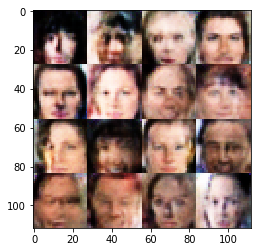

Epoch 0/1... Discriminator Loss: 1.0199... Generator Loss: 0.7865
Epoch 0/1... Discriminator Loss: 0.8380... Generator Loss: 0.8975
Epoch 0/1... Discriminator Loss: 0.3297... Generator Loss: 2.0401
Epoch 0/1... Discriminator Loss: 0.4162... Generator Loss: 2.4278
Epoch 0/1... Discriminator Loss: 1.2964... Generator Loss: 0.5402


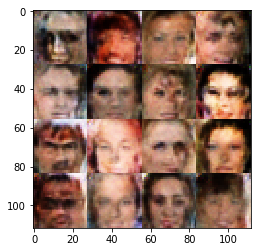

Epoch 0/1... Discriminator Loss: 0.8377... Generator Loss: 2.7029
Epoch 0/1... Discriminator Loss: 1.4674... Generator Loss: 2.1077
Epoch 0/1... Discriminator Loss: 0.1086... Generator Loss: 4.0332
Epoch 0/1... Discriminator Loss: 1.2826... Generator Loss: 1.8874
Epoch 0/1... Discriminator Loss: 1.4365... Generator Loss: 0.4841


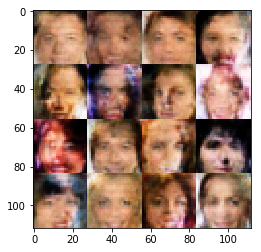

Epoch 0/1... Discriminator Loss: 0.3714... Generator Loss: 1.4734
Epoch 0/1... Discriminator Loss: 0.7610... Generator Loss: 1.4452
Epoch 0/1... Discriminator Loss: 0.1357... Generator Loss: 4.4616
Epoch 0/1... Discriminator Loss: 0.5102... Generator Loss: 3.0291
Epoch 0/1... Discriminator Loss: 0.3458... Generator Loss: 4.3979


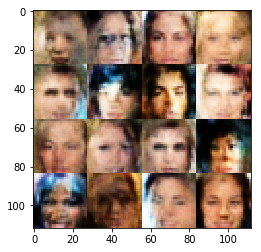

Epoch 0/1... Discriminator Loss: 0.5306... Generator Loss: 2.3025
Epoch 0/1... Discriminator Loss: 0.1563... Generator Loss: 4.3412
Epoch 0/1... Discriminator Loss: 0.2500... Generator Loss: 3.8602
Epoch 0/1... Discriminator Loss: 0.2180... Generator Loss: 3.3498
Epoch 0/1... Discriminator Loss: 1.3420... Generator Loss: 0.5012


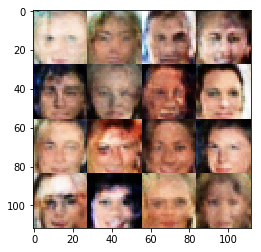

Epoch 0/1... Discriminator Loss: 0.3584... Generator Loss: 3.1237
Epoch 0/1... Discriminator Loss: 0.1370... Generator Loss: 2.8521
Epoch 0/1... Discriminator Loss: 0.3074... Generator Loss: 2.6642
Epoch 0/1... Discriminator Loss: 0.3687... Generator Loss: 2.1456
Epoch 0/1... Discriminator Loss: 1.2305... Generator Loss: 0.9438


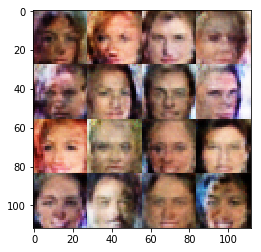

Epoch 0/1... Discriminator Loss: 0.7869... Generator Loss: 0.9201
Epoch 0/1... Discriminator Loss: 0.4010... Generator Loss: 1.9782
Epoch 0/1... Discriminator Loss: 0.2102... Generator Loss: 4.1073
Epoch 0/1... Discriminator Loss: 0.6175... Generator Loss: 1.4879
Epoch 0/1... Discriminator Loss: 0.1547... Generator Loss: 2.6206


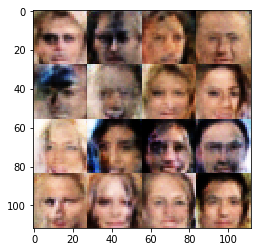

Epoch 0/1... Discriminator Loss: 0.8434... Generator Loss: 1.6820
Epoch 0/1... Discriminator Loss: 1.1443... Generator Loss: 0.6446
Epoch 0/1... Discriminator Loss: 0.7367... Generator Loss: 1.1245
Epoch 0/1... Discriminator Loss: 0.3079... Generator Loss: 2.1407
Epoch 0/1... Discriminator Loss: 1.4341... Generator Loss: 0.4918


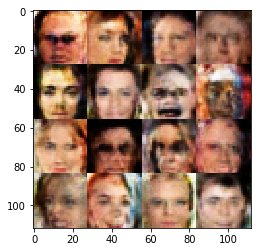

Epoch 0/1... Discriminator Loss: 0.5158... Generator Loss: 2.1880
Epoch 0/1... Discriminator Loss: 0.4013... Generator Loss: 4.0192
Epoch 0/1... Discriminator Loss: 0.7793... Generator Loss: 0.9588
Epoch 0/1... Discriminator Loss: 0.1368... Generator Loss: 3.5885
Epoch 0/1... Discriminator Loss: 0.4031... Generator Loss: 1.6002


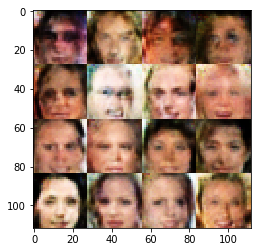

Epoch 0/1... Discriminator Loss: 1.0936... Generator Loss: 2.5151
Epoch 0/1... Discriminator Loss: 1.7722... Generator Loss: 0.2524
Epoch 0/1... Discriminator Loss: 0.6261... Generator Loss: 1.1104
Epoch 0/1... Discriminator Loss: 0.1012... Generator Loss: 6.7902
Epoch 0/1... Discriminator Loss: 1.2097... Generator Loss: 1.6955


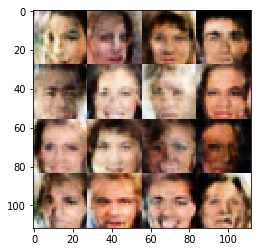

Epoch 0/1... Discriminator Loss: 0.4067... Generator Loss: 1.6542
Epoch 0/1... Discriminator Loss: 3.0242... Generator Loss: 3.8721
Epoch 0/1... Discriminator Loss: 1.1519... Generator Loss: 0.8818
Epoch 0/1... Discriminator Loss: 1.3675... Generator Loss: 0.7070
Epoch 0/1... Discriminator Loss: 0.4443... Generator Loss: 2.0966


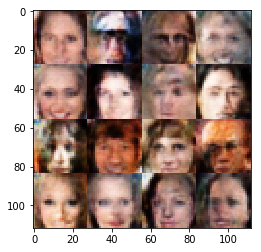

Epoch 0/1... Discriminator Loss: 0.5687... Generator Loss: 1.6324
Epoch 0/1... Discriminator Loss: 1.6901... Generator Loss: 0.3217
Epoch 0/1... Discriminator Loss: 1.0383... Generator Loss: 0.6727
Epoch 0/1... Discriminator Loss: 1.0661... Generator Loss: 0.7260
Epoch 0/1... Discriminator Loss: 0.9279... Generator Loss: 1.2613


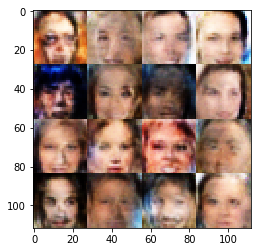

Epoch 0/1... Discriminator Loss: 0.9631... Generator Loss: 0.9081
Epoch 0/1... Discriminator Loss: 1.3151... Generator Loss: 2.0708
Epoch 0/1... Discriminator Loss: 0.5338... Generator Loss: 1.8489
Epoch 0/1... Discriminator Loss: 1.0233... Generator Loss: 0.9610
Epoch 0/1... Discriminator Loss: 0.9093... Generator Loss: 0.8193


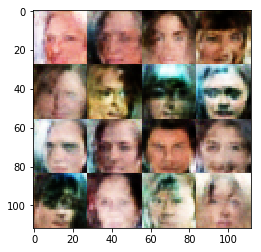

Epoch 0/1... Discriminator Loss: 1.1385... Generator Loss: 0.6073
Epoch 0/1... Discriminator Loss: 0.1584... Generator Loss: 3.6849
Epoch 0/1... Discriminator Loss: 0.8671... Generator Loss: 0.9083
Epoch 0/1... Discriminator Loss: 0.4142... Generator Loss: 1.9637
Epoch 0/1... Discriminator Loss: 0.9015... Generator Loss: 1.8702


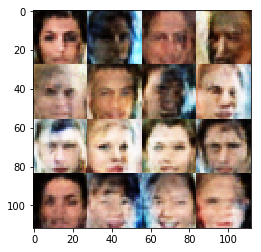

Epoch 0/1... Discriminator Loss: 0.7479... Generator Loss: 1.1659
Epoch 0/1... Discriminator Loss: 0.4311... Generator Loss: 3.0303
Epoch 0/1... Discriminator Loss: 1.2084... Generator Loss: 0.4761
Epoch 0/1... Discriminator Loss: 0.4021... Generator Loss: 2.0914
Epoch 0/1... Discriminator Loss: 0.3720... Generator Loss: 2.2538


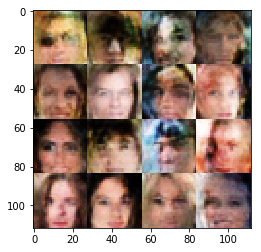

Epoch 0/1... Discriminator Loss: 0.5117... Generator Loss: 1.9951
Epoch 0/1... Discriminator Loss: 0.2139... Generator Loss: 3.9954
Epoch 0/1... Discriminator Loss: 0.9593... Generator Loss: 1.8281
Epoch 0/1... Discriminator Loss: 0.6790... Generator Loss: 2.8769
Epoch 0/1... Discriminator Loss: 0.8543... Generator Loss: 1.0230


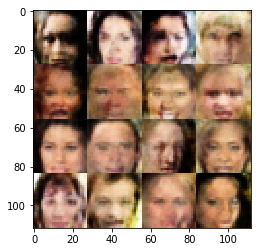

Epoch 0/1... Discriminator Loss: 0.7076... Generator Loss: 1.1021
Epoch 0/1... Discriminator Loss: 0.4734... Generator Loss: 1.9227
Epoch 0/1... Discriminator Loss: 0.0724... Generator Loss: 5.3416
Epoch 0/1... Discriminator Loss: 0.4784... Generator Loss: 1.7619
Epoch 0/1... Discriminator Loss: 1.1928... Generator Loss: 0.8018


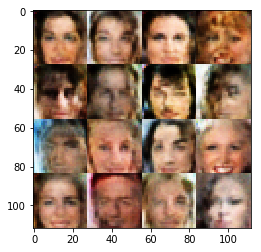

Epoch 0/1... Discriminator Loss: 1.0134... Generator Loss: 0.9308
Epoch 0/1... Discriminator Loss: 0.1510... Generator Loss: 3.2944
Epoch 0/1... Discriminator Loss: 0.0825... Generator Loss: 4.2126
Epoch 0/1... Discriminator Loss: 0.5886... Generator Loss: 2.0727
Epoch 0/1... Discriminator Loss: 0.5674... Generator Loss: 2.0079


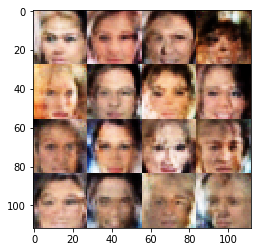

Epoch 0/1... Discriminator Loss: 0.5112... Generator Loss: 3.2779
Epoch 0/1... Discriminator Loss: 0.5128... Generator Loss: 2.3463
Epoch 0/1... Discriminator Loss: 0.7092... Generator Loss: 1.2685
Epoch 0/1... Discriminator Loss: 0.1273... Generator Loss: 5.2487
Epoch 0/1... Discriminator Loss: 0.3498... Generator Loss: 2.5701


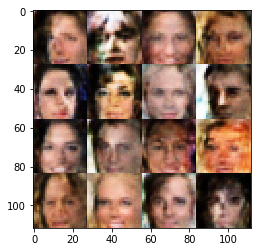

Epoch 0/1... Discriminator Loss: 0.8465... Generator Loss: 0.7993
Epoch 0/1... Discriminator Loss: 0.2037... Generator Loss: 3.0688
Epoch 0/1... Discriminator Loss: 0.4103... Generator Loss: 2.0176
Epoch 0/1... Discriminator Loss: 0.6201... Generator Loss: 0.9796
Epoch 0/1... Discriminator Loss: 0.2375... Generator Loss: 3.8312


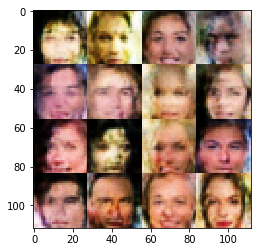

Epoch 0/1... Discriminator Loss: 1.5060... Generator Loss: 0.3265
Epoch 0/1... Discriminator Loss: 0.4035... Generator Loss: 1.6931
Epoch 0/1... Discriminator Loss: 1.0864... Generator Loss: 1.7280
Epoch 0/1... Discriminator Loss: 0.3290... Generator Loss: 2.4236
Epoch 0/1... Discriminator Loss: 0.4234... Generator Loss: 1.6477


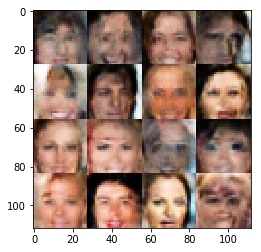

Epoch 0/1... Discriminator Loss: 0.4208... Generator Loss: 2.2687
Epoch 0/1... Discriminator Loss: 0.9712... Generator Loss: 2.1002
Epoch 0/1... Discriminator Loss: 0.9141... Generator Loss: 1.3919
Epoch 0/1... Discriminator Loss: 0.8693... Generator Loss: 1.9447
Epoch 0/1... Discriminator Loss: 1.5911... Generator Loss: 0.2898


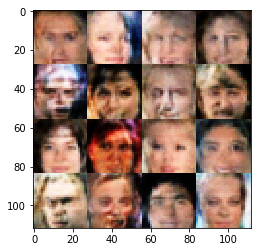

Epoch 0/1... Discriminator Loss: 0.7164... Generator Loss: 1.1958
Epoch 0/1... Discriminator Loss: 0.2791... Generator Loss: 3.2095
Epoch 0/1... Discriminator Loss: 0.2240... Generator Loss: 3.6359
Epoch 0/1... Discriminator Loss: 0.7583... Generator Loss: 1.3520
Epoch 0/1... Discriminator Loss: 0.4592... Generator Loss: 2.0743


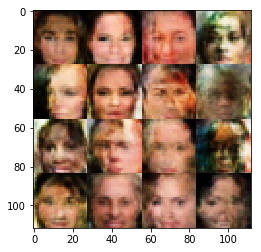

Epoch 0/1... Discriminator Loss: 0.1821... Generator Loss: 3.1611
Epoch 0/1... Discriminator Loss: 0.4280... Generator Loss: 1.3683
Epoch 0/1... Discriminator Loss: 0.6345... Generator Loss: 1.2591
Epoch 0/1... Discriminator Loss: 1.0051... Generator Loss: 0.7869
Epoch 0/1... Discriminator Loss: 1.0697... Generator Loss: 0.4717


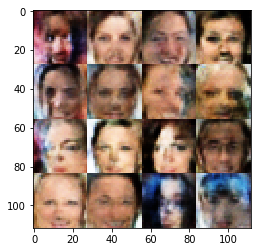

Epoch 0/1... Discriminator Loss: 0.9935... Generator Loss: 0.7704
Epoch 0/1... Discriminator Loss: 0.9301... Generator Loss: 0.8339
Epoch 0/1... Discriminator Loss: 0.8288... Generator Loss: 1.3652
Epoch 0/1... Discriminator Loss: 0.5826... Generator Loss: 1.2180
Epoch 0/1... Discriminator Loss: 1.0713... Generator Loss: 2.9170


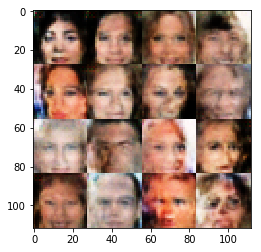

Epoch 0/1... Discriminator Loss: 0.3443... Generator Loss: 4.1018
Epoch 0/1... Discriminator Loss: 1.3488... Generator Loss: 0.6465
Epoch 0/1... Discriminator Loss: 0.7253... Generator Loss: 1.0332
Epoch 0/1... Discriminator Loss: 0.7582... Generator Loss: 1.6529
Epoch 0/1... Discriminator Loss: 0.4639... Generator Loss: 3.0125


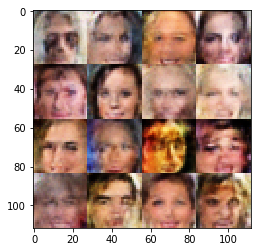

Epoch 0/1... Discriminator Loss: 0.6696... Generator Loss: 1.8963
Epoch 0/1... Discriminator Loss: 0.9351... Generator Loss: 0.7372
Epoch 0/1... Discriminator Loss: 0.6241... Generator Loss: 2.1573
Epoch 0/1... Discriminator Loss: 1.4133... Generator Loss: 0.3540
Epoch 0/1... Discriminator Loss: 0.5651... Generator Loss: 2.1409


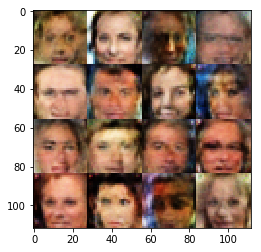

Epoch 0/1... Discriminator Loss: 0.4684... Generator Loss: 2.3033
Epoch 0/1... Discriminator Loss: 0.6590... Generator Loss: 1.0860
Epoch 0/1... Discriminator Loss: 0.9464... Generator Loss: 1.7572
Epoch 0/1... Discriminator Loss: 0.3577... Generator Loss: 1.9586
Epoch 0/1... Discriminator Loss: 0.0753... Generator Loss: 4.6551


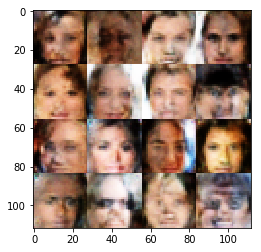

Epoch 0/1... Discriminator Loss: 1.1180... Generator Loss: 1.5060
Epoch 0/1... Discriminator Loss: 0.1405... Generator Loss: 3.3520
Epoch 0/1... Discriminator Loss: 1.9212... Generator Loss: 0.2581
Epoch 0/1... Discriminator Loss: 0.9785... Generator Loss: 0.7782
Epoch 0/1... Discriminator Loss: 0.4851... Generator Loss: 1.8828


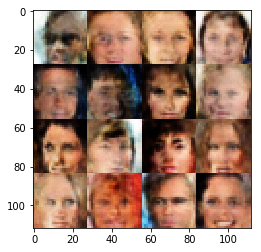

Epoch 0/1... Discriminator Loss: 1.0422... Generator Loss: 2.1065
Epoch 0/1... Discriminator Loss: 0.6689... Generator Loss: 1.2535
Epoch 0/1... Discriminator Loss: 0.4837... Generator Loss: 2.0164
Epoch 0/1... Discriminator Loss: 0.4778... Generator Loss: 1.5662
Epoch 0/1... Discriminator Loss: 2.6510... Generator Loss: 0.0821


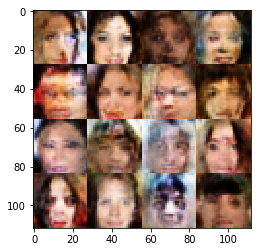

Epoch 0/1... Discriminator Loss: 0.6991... Generator Loss: 1.1781
Epoch 0/1... Discriminator Loss: 0.9700... Generator Loss: 0.7230
Epoch 0/1... Discriminator Loss: 0.6191... Generator Loss: 1.2532
Epoch 0/1... Discriminator Loss: 1.1196... Generator Loss: 0.6470
Epoch 0/1... Discriminator Loss: 0.7795... Generator Loss: 1.1557


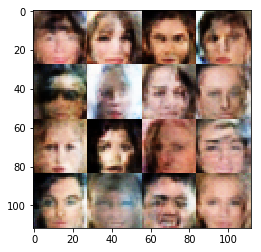

Epoch 0/1... Discriminator Loss: 0.8807... Generator Loss: 0.5692
Epoch 0/1... Discriminator Loss: 0.5729... Generator Loss: 2.3812
Epoch 0/1... Discriminator Loss: 3.3537... Generator Loss: 2.7850
Epoch 0/1... Discriminator Loss: 0.1506... Generator Loss: 4.2560
Epoch 0/1... Discriminator Loss: 0.1877... Generator Loss: 3.5115


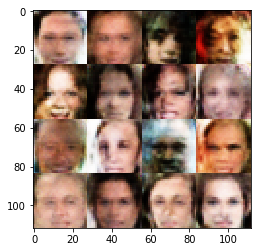

Epoch 0/1... Discriminator Loss: 0.2340... Generator Loss: 2.7261
Epoch 0/1... Discriminator Loss: 1.4643... Generator Loss: 0.4612
Epoch 0/1... Discriminator Loss: 1.6811... Generator Loss: 0.2616
Epoch 0/1... Discriminator Loss: 0.3778... Generator Loss: 4.4182
Epoch 0/1... Discriminator Loss: 0.6680... Generator Loss: 2.0678


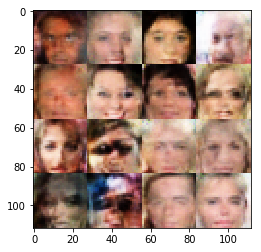

Epoch 0/1... Discriminator Loss: 1.1347... Generator Loss: 0.5707
Epoch 0/1... Discriminator Loss: 0.4792... Generator Loss: 2.1460
Epoch 0/1... Discriminator Loss: 0.4464... Generator Loss: 2.5759
Epoch 0/1... Discriminator Loss: 1.6549... Generator Loss: 1.4931
Epoch 0/1... Discriminator Loss: 0.6610... Generator Loss: 1.9198


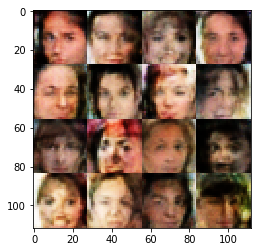

Epoch 0/1... Discriminator Loss: 1.6553... Generator Loss: 0.4983
Epoch 0/1... Discriminator Loss: 1.2937... Generator Loss: 0.6376
Epoch 0/1... Discriminator Loss: 0.8935... Generator Loss: 0.7396
Epoch 0/1... Discriminator Loss: 0.7359... Generator Loss: 1.2962
Epoch 0/1... Discriminator Loss: 1.2131... Generator Loss: 0.8944


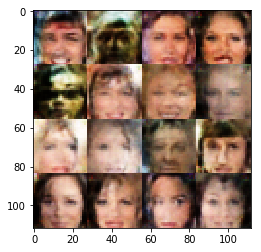

Epoch 0/1... Discriminator Loss: 0.6225... Generator Loss: 2.9480
Epoch 0/1... Discriminator Loss: 0.9396... Generator Loss: 1.2749
Epoch 0/1... Discriminator Loss: 0.5376... Generator Loss: 1.7047
Epoch 0/1... Discriminator Loss: 0.8173... Generator Loss: 4.3089
Epoch 0/1... Discriminator Loss: 0.6817... Generator Loss: 1.4203


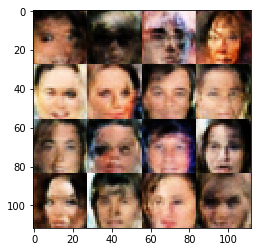

Epoch 0/1... Discriminator Loss: 0.7475... Generator Loss: 1.0107
Epoch 0/1... Discriminator Loss: 0.8794... Generator Loss: 1.9796
Epoch 0/1... Discriminator Loss: 2.1172... Generator Loss: 2.8093
Epoch 0/1... Discriminator Loss: 0.2710... Generator Loss: 2.6765
Epoch 0/1... Discriminator Loss: 0.6698... Generator Loss: 1.1801


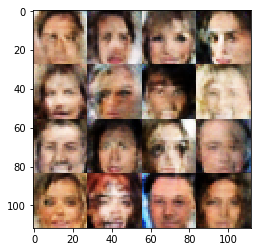

Epoch 0/1... Discriminator Loss: 1.6255... Generator Loss: 0.4603
Epoch 0/1... Discriminator Loss: 0.8034... Generator Loss: 1.0778
Epoch 0/1... Discriminator Loss: 0.4530... Generator Loss: 2.1763
Epoch 0/1... Discriminator Loss: 0.6229... Generator Loss: 1.7447
Epoch 0/1... Discriminator Loss: 1.2376... Generator Loss: 1.5043


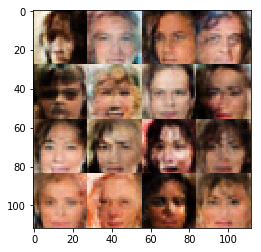

Epoch 0/1... Discriminator Loss: 0.5531... Generator Loss: 2.2129
Epoch 0/1... Discriminator Loss: 0.4483... Generator Loss: 1.2514
Epoch 0/1... Discriminator Loss: 0.8392... Generator Loss: 1.9053
Epoch 0/1... Discriminator Loss: 0.3147... Generator Loss: 2.6830
Epoch 0/1... Discriminator Loss: 0.2407... Generator Loss: 2.9033


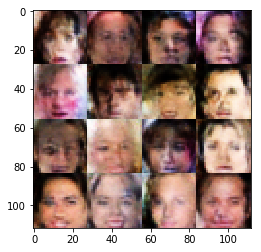

Epoch 0/1... Discriminator Loss: 1.2052... Generator Loss: 0.6966
Epoch 0/1... Discriminator Loss: 0.9243... Generator Loss: 0.8492
Epoch 0/1... Discriminator Loss: 1.4567... Generator Loss: 2.6763
Epoch 0/1... Discriminator Loss: 0.2534... Generator Loss: 3.7274
Epoch 0/1... Discriminator Loss: 0.3530... Generator Loss: 1.9792


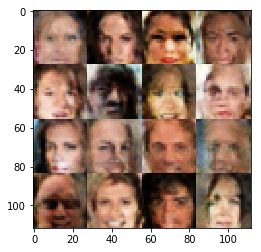

Epoch 0/1... Discriminator Loss: 1.0106... Generator Loss: 1.3595
Epoch 0/1... Discriminator Loss: 0.8413... Generator Loss: 0.9967
Epoch 0/1... Discriminator Loss: 0.9824... Generator Loss: 1.9671
Epoch 0/1... Discriminator Loss: 0.5073... Generator Loss: 2.0021
Epoch 0/1... Discriminator Loss: 0.4382... Generator Loss: 1.6523


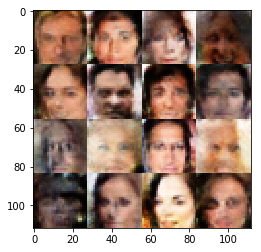

Epoch 0/1... Discriminator Loss: 1.1389... Generator Loss: 0.6993
Epoch 0/1... Discriminator Loss: 1.3307... Generator Loss: 0.6786
Epoch 0/1... Discriminator Loss: 0.4440... Generator Loss: 1.6987
Epoch 0/1... Discriminator Loss: 0.4307... Generator Loss: 5.4462
Epoch 0/1... Discriminator Loss: 1.4342... Generator Loss: 0.5193


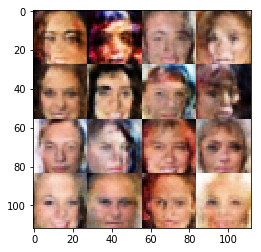

Epoch 0/1... Discriminator Loss: 0.1672... Generator Loss: 3.9032
Epoch 0/1... Discriminator Loss: 1.3621... Generator Loss: 0.5482
Epoch 0/1... Discriminator Loss: 0.5360... Generator Loss: 1.1834
Epoch 0/1... Discriminator Loss: 0.2882... Generator Loss: 2.8209
Epoch 0/1... Discriminator Loss: 0.4072... Generator Loss: 4.7679


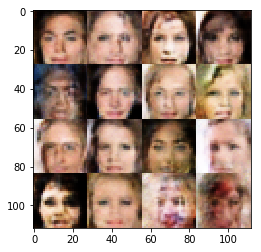

Epoch 0/1... Discriminator Loss: 1.5432... Generator Loss: 0.3661
Epoch 0/1... Discriminator Loss: 1.2270... Generator Loss: 0.8797
Epoch 0/1... Discriminator Loss: 1.6074... Generator Loss: 2.8307
Epoch 0/1... Discriminator Loss: 0.0811... Generator Loss: 5.0164
Epoch 0/1... Discriminator Loss: 0.2851... Generator Loss: 4.0370


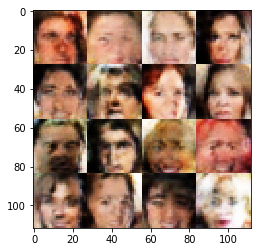

Epoch 0/1... Discriminator Loss: 0.7768... Generator Loss: 1.0179
Epoch 0/1... Discriminator Loss: 1.3106... Generator Loss: 0.6749
Epoch 0/1... Discriminator Loss: 1.5982... Generator Loss: 0.3893
Epoch 0/1... Discriminator Loss: 0.2888... Generator Loss: 3.4829
Epoch 0/1... Discriminator Loss: 0.3845... Generator Loss: 3.5970


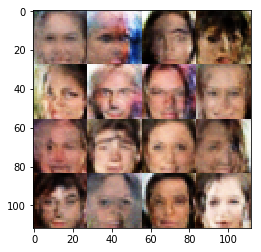

Epoch 0/1... Discriminator Loss: 1.0942... Generator Loss: 1.8836
Epoch 0/1... Discriminator Loss: 1.0545... Generator Loss: 0.8849
Epoch 0/1... Discriminator Loss: 0.5339... Generator Loss: 1.8396
Epoch 0/1... Discriminator Loss: 0.5176... Generator Loss: 3.8682
Epoch 0/1... Discriminator Loss: 0.2820... Generator Loss: 2.3796


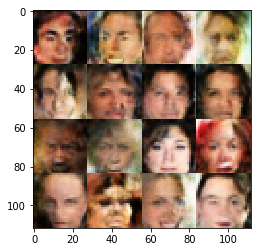

Epoch 0/1... Discriminator Loss: 1.9743... Generator Loss: 0.2696
Epoch 0/1... Discriminator Loss: 0.5959... Generator Loss: 1.3060
Epoch 0/1... Discriminator Loss: 1.1046... Generator Loss: 1.2429
Epoch 0/1... Discriminator Loss: 0.3588... Generator Loss: 1.7387
Epoch 0/1... Discriminator Loss: 1.6980... Generator Loss: 1.7331


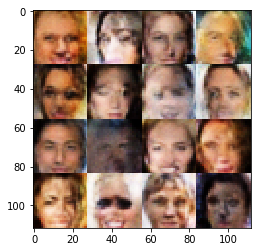

Epoch 0/1... Discriminator Loss: 0.5759... Generator Loss: 1.3513
Epoch 0/1... Discriminator Loss: 1.3036... Generator Loss: 0.7931
Epoch 0/1... Discriminator Loss: 0.5752... Generator Loss: 1.2758
Epoch 0/1... Discriminator Loss: 0.9873... Generator Loss: 0.7592
Epoch 0/1... Discriminator Loss: 0.7663... Generator Loss: 1.0387


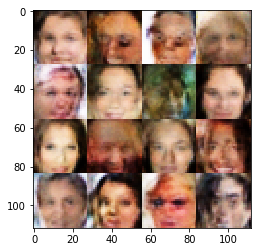

Epoch 0/1... Discriminator Loss: 0.6651... Generator Loss: 1.1360
Epoch 0/1... Discriminator Loss: 0.3780... Generator Loss: 4.1757
Epoch 0/1... Discriminator Loss: 0.7949... Generator Loss: 0.8112
Epoch 0/1... Discriminator Loss: 0.3739... Generator Loss: 3.5500
Epoch 0/1... Discriminator Loss: 1.0854... Generator Loss: 0.5799


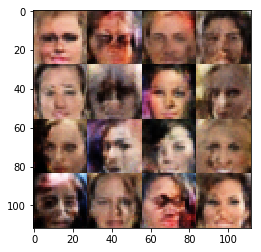

Epoch 0/1... Discriminator Loss: 0.8224... Generator Loss: 0.8558
Epoch 0/1... Discriminator Loss: 0.2006... Generator Loss: 3.1690
Epoch 0/1... Discriminator Loss: 0.3537... Generator Loss: 2.2720
Epoch 0/1... Discriminator Loss: 0.6572... Generator Loss: 1.9315
Epoch 0/1... Discriminator Loss: 0.7309... Generator Loss: 3.3509


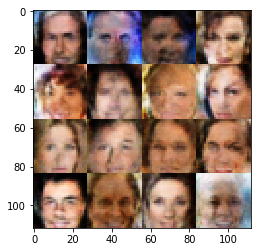

Epoch 0/1... Discriminator Loss: 0.7230... Generator Loss: 1.3056
Epoch 0/1... Discriminator Loss: 0.9918... Generator Loss: 1.0793
Epoch 0/1... Discriminator Loss: 0.8652... Generator Loss: 2.1873
Epoch 0/1... Discriminator Loss: 0.5150... Generator Loss: 2.1124
Epoch 0/1... Discriminator Loss: 0.2786... Generator Loss: 3.2507


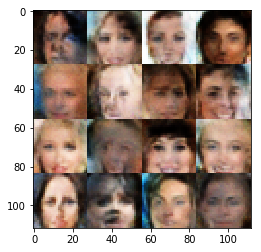

Epoch 0/1... Discriminator Loss: 0.6288... Generator Loss: 1.1791
Epoch 0/1... Discriminator Loss: 0.1469... Generator Loss: 3.0274
Epoch 0/1... Discriminator Loss: 1.2900... Generator Loss: 0.6962
Epoch 0/1... Discriminator Loss: 0.6399... Generator Loss: 1.4602
Epoch 0/1... Discriminator Loss: 1.3053... Generator Loss: 0.6751


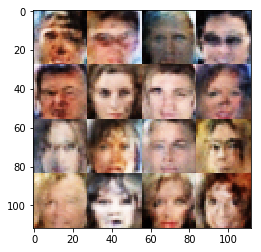

Epoch 0/1... Discriminator Loss: 1.1553... Generator Loss: 0.8652
Epoch 0/1... Discriminator Loss: 0.9673... Generator Loss: 0.8952
Epoch 0/1... Discriminator Loss: 0.9445... Generator Loss: 0.9901
Epoch 0/1... Discriminator Loss: 0.7685... Generator Loss: 1.5982
Epoch 0/1... Discriminator Loss: 1.0953... Generator Loss: 0.6463


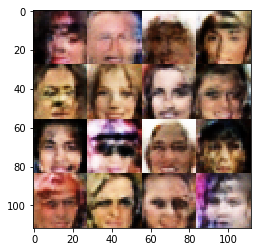

Epoch 0/1... Discriminator Loss: 0.5835... Generator Loss: 1.4584
Epoch 0/1... Discriminator Loss: 1.4567... Generator Loss: 0.4095
Epoch 0/1... Discriminator Loss: 0.8424... Generator Loss: 0.8649
Epoch 0/1... Discriminator Loss: 1.0064... Generator Loss: 1.8392
Epoch 0/1... Discriminator Loss: 0.5732... Generator Loss: 1.2121


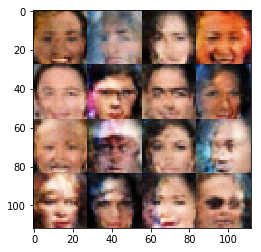

Epoch 0/1... Discriminator Loss: 0.1587... Generator Loss: 3.4749
Epoch 0/1... Discriminator Loss: 1.1337... Generator Loss: 0.6245
Epoch 0/1... Discriminator Loss: 1.0661... Generator Loss: 0.6930
Epoch 0/1... Discriminator Loss: 0.4409... Generator Loss: 2.3625
Epoch 0/1... Discriminator Loss: 0.6138... Generator Loss: 3.3536


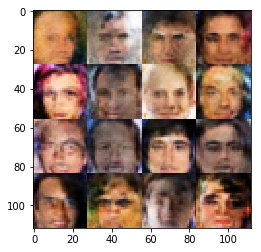

Epoch 0/1... Discriminator Loss: 1.7686... Generator Loss: 0.3382
Epoch 0/1... Discriminator Loss: 1.1356... Generator Loss: 0.8163
Epoch 0/1... Discriminator Loss: 0.4378... Generator Loss: 1.5684
Epoch 0/1... Discriminator Loss: 0.6078... Generator Loss: 2.1817
Epoch 0/1... Discriminator Loss: 0.3594... Generator Loss: 2.7376


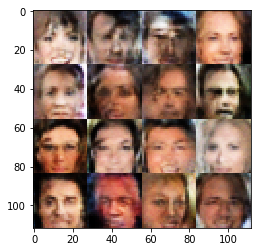

Epoch 0/1... Discriminator Loss: 1.1244... Generator Loss: 0.8868
Epoch 0/1... Discriminator Loss: 1.8535... Generator Loss: 0.4798
Epoch 0/1... Discriminator Loss: 0.5754... Generator Loss: 1.2658
Epoch 0/1... Discriminator Loss: 0.8274... Generator Loss: 0.9013
Epoch 0/1... Discriminator Loss: 0.7362... Generator Loss: 1.6763


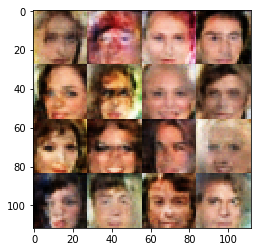

Epoch 0/1... Discriminator Loss: 1.1551... Generator Loss: 0.4915
Epoch 0/1... Discriminator Loss: 0.4026... Generator Loss: 1.7331
Epoch 0/1... Discriminator Loss: 0.7995... Generator Loss: 1.2592
Epoch 0/1... Discriminator Loss: 0.6311... Generator Loss: 1.1503
Epoch 0/1... Discriminator Loss: 0.7820... Generator Loss: 1.3855


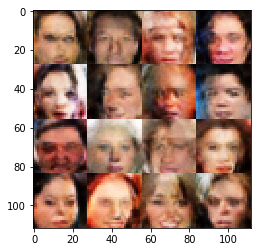

Epoch 0/1... Discriminator Loss: 0.5535... Generator Loss: 1.6060
Epoch 0/1... Discriminator Loss: 0.5607... Generator Loss: 1.2193
Epoch 0/1... Discriminator Loss: 0.3092... Generator Loss: 3.5438
Epoch 0/1... Discriminator Loss: 0.8542... Generator Loss: 1.0038
Epoch 0/1... Discriminator Loss: 1.6748... Generator Loss: 0.3386


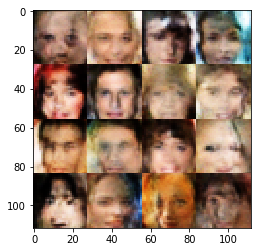

Epoch 0/1... Discriminator Loss: 0.6335... Generator Loss: 1.4465
Epoch 0/1... Discriminator Loss: 0.9968... Generator Loss: 0.9111
Epoch 0/1... Discriminator Loss: 0.1485... Generator Loss: 4.9123
Epoch 0/1... Discriminator Loss: 0.6733... Generator Loss: 1.1585
Epoch 0/1... Discriminator Loss: 0.6204... Generator Loss: 1.3136


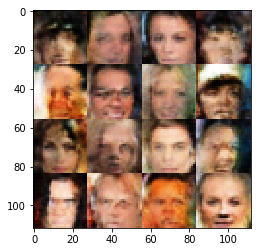

Epoch 0/1... Discriminator Loss: 1.8930... Generator Loss: 3.0738
Epoch 0/1... Discriminator Loss: 0.8494... Generator Loss: 1.2653
Epoch 0/1... Discriminator Loss: 0.5200... Generator Loss: 2.8879
Epoch 0/1... Discriminator Loss: 0.6422... Generator Loss: 1.8449
Epoch 0/1... Discriminator Loss: 0.2766... Generator Loss: 3.5838


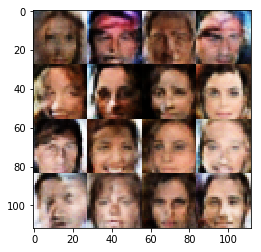

Epoch 0/1... Discriminator Loss: 0.8804... Generator Loss: 2.1124
Epoch 0/1... Discriminator Loss: 0.5660... Generator Loss: 1.4769
Epoch 0/1... Discriminator Loss: 0.1743... Generator Loss: 3.9556
Epoch 0/1... Discriminator Loss: 0.3806... Generator Loss: 1.9217
Epoch 0/1... Discriminator Loss: 1.6145... Generator Loss: 0.4257


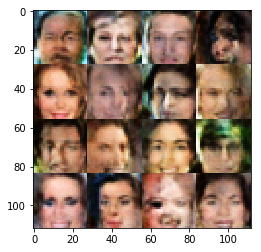

Epoch 0/1... Discriminator Loss: 0.8009... Generator Loss: 1.3248
Epoch 0/1... Discriminator Loss: 0.4034... Generator Loss: 2.2645
Epoch 0/1... Discriminator Loss: 0.3460... Generator Loss: 3.4441
Epoch 0/1... Discriminator Loss: 0.6419... Generator Loss: 1.2842
Epoch 0/1... Discriminator Loss: 0.7410... Generator Loss: 1.2451


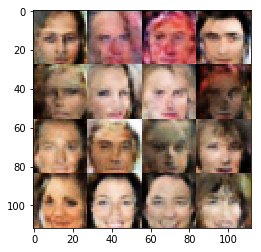

Epoch 0/1... Discriminator Loss: 0.2008... Generator Loss: 4.3676
Epoch 0/1... Discriminator Loss: 1.0040... Generator Loss: 1.0292
Epoch 0/1... Discriminator Loss: 0.4694... Generator Loss: 2.4152
Epoch 0/1... Discriminator Loss: 0.7036... Generator Loss: 1.3749
Epoch 0/1... Discriminator Loss: 0.2822... Generator Loss: 3.6749


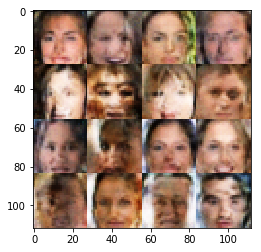

Epoch 0/1... Discriminator Loss: 1.3916... Generator Loss: 0.9807
Epoch 0/1... Discriminator Loss: 0.7394... Generator Loss: 1.4059
Epoch 0/1... Discriminator Loss: 0.8096... Generator Loss: 1.0204
Epoch 0/1... Discriminator Loss: 0.7308... Generator Loss: 1.1723
Epoch 0/1... Discriminator Loss: 1.4518... Generator Loss: 0.3704


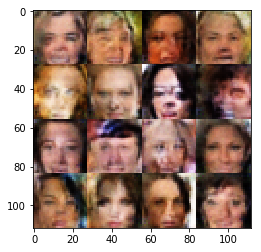

Epoch 0/1... Discriminator Loss: 1.0094... Generator Loss: 3.3021
Epoch 0/1... Discriminator Loss: 1.0239... Generator Loss: 0.8090
Epoch 0/1... Discriminator Loss: 0.6270... Generator Loss: 2.1245
Epoch 0/1... Discriminator Loss: 0.6355... Generator Loss: 1.3803


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.